In [1]:
# Importaciones de librerias estándar
import pandas as pd
import numpy as np
import missingno as msg

# Importaciones relacionadas con visualización
import matplotlib.pyplot as plt
import plotly.express as px
from matplotlib.ticker import FuncFormatter
import seaborn as sns

# Configurar seaborn para visualización
sns.set()

#### Importar archivo

In [ ]:
# Ruta del archivo 
file_path = r'C:\Users\Guille Laion\OneDrive\Documentos\Documentos\worksample.csv'

# Leer los archivo Excel 
df = pd.read_csv(file_path, encoding='latin1', sep=';')

# Configurar opciones para visualización
pd.set_option('display.max_columns', 20)

#### Analisis General de los Datos

En esta primera parte se realizara un analisis general de los datos, corrigiendo los nombres de algunas columnas, el tipo de datos que estas contienen y unificando algunos nombres de los Bancos y de los tipo de cuentas que tiene la base. Esto permite una mejor interpretacion en los analisis.

In [3]:
df

,Fecha,Banco,Cuenta,Moneda,Monto,TipoMovimiento
0,22/3/24,Banco Macro,Caja de Ahorro 001,EUR,"-2113,12",Egreso
1,19/4/24,Banco BBVA,Cuenta Corriente 123,EUR,"-1503,81",Egreso
2,8/8/24,Banco Nacin,Caja de Ahorro 456,USD,"-2281,75",Egreso
3,7/12/24,Banco BBVA,Caja de Ahorro 001,EUR,"3804,1",Ingreso
4,12/1/24,Banco Macro,Caja de Ahorro 456,ARS,"-1097,63",Egreso
...,...,...,...,...,...,...
14635,3/8/24,Banco BBVA,Caja de Ahorro 456,ARS,"4678,43",Ingreso
14636,10/7/24,Banco Macro,Cuenta Corriente 789,EUR,"-1603,85",Egreso
14637,27/9/24,Banco Macro,Cuenta Corriente 123,EUR,"-767,94",Egreso
14638,29/11/24,Banco Santander,Caja de Ahorro 456,ARS,"-1879,22",Egreso


In [4]:
# Revisión general
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Fecha           14640 non-null  object
 1   Banco           14640 non-null  object
 2   Cuenta          14640 non-null  object
 3   Moneda          14640 non-null  object
 4   Monto           14640 non-null  object
 5   TipoMovimiento  14640 non-null  object
dtypes: object(6)
memory usage: 686.4+ KB


In [5]:
# Revision de valores nulos
df.isna().sum()

Fecha             0
Banco             0
Cuenta            0
Moneda            0
Monto             0
TipoMovimiento    0
dtype: int64

In [6]:
# Control de valores duplicados
# Verificar duplicados exactos
r_duplicados = df.duplicated(keep=False).sum()
print(f'Duplicados exactos encontrados: {r_duplicados}')

Duplicados exactos encontrados: 0


In [7]:
# Ver los tipos de datos de cada columna
df.dtypes

Fecha             object
Banco             object
Cuenta            object
Moneda            object
Monto             object
TipoMovimiento    object
dtype: object

In [8]:
# Deterninar el número de valores únicos por columna
# Esto es útil para entender la diversidad de datos en cada columna
df.nunique()

Fecha               366
Banco                 7
Cuenta                4
Moneda                3
Monto             14463
TipoMovimiento        2
dtype: int64

#### Estandarizá los nombres de los bancos, eliminando textos redundantes y normalizando variantes.

In [9]:
df['Banco'].unique()


array(['Banco Macro', 'Banco BBVA', 'Banco Naci\x97n', 'Banco Santander',
       'Banco de Galicia', 'Banco Galicia', 'Banco Nacion'], dtype=object)

In [10]:
df['Banco'].value_counts()

Banco
Banco Macro         2928
Banco BBVA          2928
Banco Santander     2928
Banco Nacin        2196
Banco de Galicia    1982
Banco Galicia        946
Banco Nacion         732
Name: count, dtype: int64

In [11]:
# corrección de nombres de bancos
df['Banco'] = df['Banco'].replace({
    'Banco Nacin': 'Banco Nacion',
    'Banco Nación': 'Banco Nacion',
    'Banco Bbva': 'Banco BBVA',
    'Banco de Galicia': 'Banco Galicia'
})
# mapear a códigos, una vez corregidos los nombres  designarles códigos (podria ser un diccionario acorde a el CUIT de cada banco)
banco_codigos = {
    'Banco Nacion': 'B01',
    'Banco BBVA': 'B02',
    'Banco Galicia': 'B03',
    'Banco Santander': 'B04',
    'Banco Macro': 'B05',
}

df['Codigo_Banco'] = df['Banco'].map(banco_codigos)

Deberia conciderarse algun tipo de nomenclador donde se pueda tener los nombres de los bancos, de los tipos de cuenta con los numeros de las cuentas, las diferentes monedas que se usen, todo con algun tipo de id unico por cada tipo de movimiento.

#### Convertí las fechas al formato datetime y generá columnas adicionales que indiquen el mes, el día de la semana y el trimestre.

In [12]:
# cambio el formato de la columna Fecha dado que es un object y deberia ser datetime
df['Fecha'] = pd.to_datetime(df['Fecha'], format='%d/%m/%y')

# Creación de nuevas columnas basadas en la columna Fecha
df['Año'] = df['Fecha'].dt.year
df['Mes'] = df['Fecha'].dt.month
df['DiaSemana'] = df['Fecha'].dt.strftime('%A') 
df['Trimestre'] = df['Fecha'].dt.to_period('Q')

Con respecto al campo de fecha, sería necesario revisar por qué no se está almacenando con un formato de fecha adecuado. Asimismo, podría considerarse que, al momento de grabar la transacción, se desagregue automáticamente en año, mes, día y cuatrimestre, de modo de agilizar y simplificar los análisis posteriores.

#### Creá una columna que clasifique las cuentas según su tipo (e.g., "Ahorro" o "Corriente").

In [13]:
# Crear una nueva columna 'TipoCuenta' basada en la columna 'Cuenta' - Podria ponerse cualqier otro nombre segun criterio del área. 
df['TipoCuenta'] = np.where(df['Cuenta'].str.contains('Ahorro', case=False), 'Ahorro', 'Corriente')

In [14]:
df['TipoCuenta'].unique()

array(['Ahorro', 'Corriente'], dtype=object)

In [15]:
df['TipoCuenta'].value_counts()

TipoCuenta
Ahorro       7320
Corriente    7320
Name: count, dtype: int64

#### Cambiar el formato de los valores de la columna Montos, para poder realizar operaciones sobre la misma.

In [16]:
# Reemplazar coma por punto y convertir a float
df["Monto"] = df["Monto"].str.replace(',', '.').astype(float)

In [17]:
# Ver algunas estadísticas descriptivas del Monto para primer analisis de los valores que contiene. La misma hay que desagregarla por Moneda y Tipo de Movimiento dado que 
# no es lo mismo un movimiento en pesos que en dolares, y no es lo mismo un egreso que un ingreso.

estadisticas_por_banco = df.groupby(['Moneda', 'TipoMovimiento'])['Monto'].describe().round(0)

estadisticas_por_banco

count    mean     std     min     25%     50%     75%  \
Moneda TipoMovimiento                                                           
ARS    Egreso          2475.0 -1266.0   702.0 -2498.0 -1867.0 -1271.0  -653.0   
       Ingreso         2475.0  2542.0  1436.0   100.0  1293.0  2522.0  3824.0   
EUR    Egreso          2415.0 -1301.0   708.0 -2500.0 -1924.0 -1326.0  -692.0   
       Ingreso         2415.0  2570.0  1413.0   104.0  1352.0  2631.0  3799.0   
USD    Egreso          2430.0 -1260.0   714.0 -2500.0 -1876.0 -1251.0  -644.0   
       Ingreso         2430.0  2542.0  1410.0   101.0  1270.0  2596.0  3742.0   

                          max  
Moneda TipoMovimiento          
ARS    Egreso           -51.0  
       Ingreso         4998.0  
EUR    Egreso           -51.0  
       Ingreso         4999.0  
USD    Egreso           -54.0  
       Ingreso         5000.0

La columna Monto debería almacenarse siempre como valor positivo, utilizando Tipo de Movimiento para determinar si se trata de un ingreso o un egreso. Esto evita la ambigüedad de manejar signos en el monto y simplifica el análisis.

Además, se recomienda clasificar las transacciones según su naturaleza: transferencias internas entre cuentas del mismo banco, movimientos entre bancos, o transacciones externas. Incorporar un campo de concepto o categoría de transacción permitiría identificar de forma más precisa el origen y destino de los fondos.

#### Detectá movimientos inusuales en los montos.

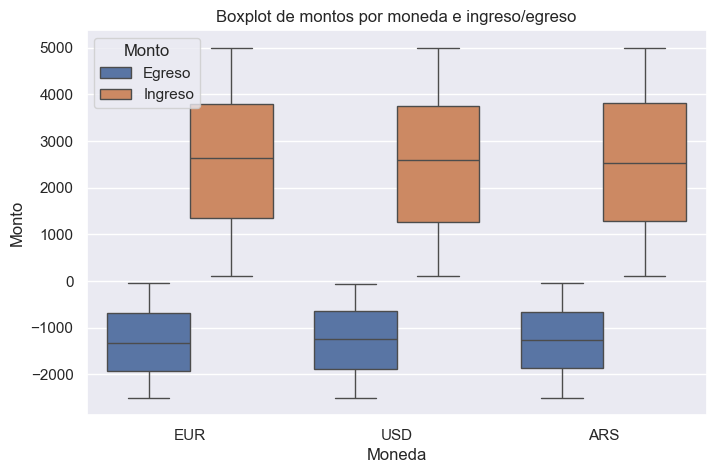

In [18]:
# Para poder ver algunas desviaciones, un primer analisis interesante para hacer es el Boxplot, permite ver si hay outliers
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x="Moneda", y="Monto", hue=(df['Monto']>0).map({True:"Ingreso", False:"Egreso"}))
plt.title("Boxplot de montos por moneda e ingreso/egreso")
plt.show()


No se puede ver a simple vista si hay valores fuera de lo normal, por ello se pasa a hacer un analisis teniendo en cuenta la cantidad de movimientos que tienen las cuentas por dia para las distintas moneda, seria interesante ver las mismas por hora. Ademas, como los montos son de diferentes monedas, hay que conciderar hacer un analisis por separado de cada una, viendo si los montos que se transaccionaron son muy elevados, ejemplo entradas y salida de dinero muy grandes, las cuales llamaremos salidas espejo, por otro lado puede haber muchas transacciones de montos bajos en un mismo día lo cual puede indicar algun tipo de movimento inusual. 



In [19]:
### Realizar un análisis de outliers por grupo (TipoMovimiento y Moneda o Banco y Moneda) entre los distintos montos de las transacciones.

outliers_por_grupo = []

# Primiero agrupo por tipo de movimiento y Moneda (podria hacerse por banco y moneda)
 
for (tipomovimiento, moneda), grupo in df.groupby(['TipoMovimiento', 'Moneda']):  
    Q1 = grupo['Monto'].quantile(0.25)
    Q3 = grupo['Monto'].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR

    # Selecciono los outliers en este grupo
    outliers = grupo[(grupo['Monto'] < limite_inferior) | (grupo['Monto'] > limite_superior)]
    
    # veo los datos del grupo
    outliers['Limite_Inferior'] = limite_inferior
    outliers['Limite_Superior'] = limite_superior
    outliers['IQR'] = IQR
    outliers_por_grupo.append(outliers)

# Concateno todos los DataFrames de outliers en uno solo
outliers_df = pd.concat(outliers_por_grupo)

# selecciono las columnas relevantes y ordeno el DataFrame
columnas_orden = ['Banco', 'Moneda', 'TipoMovimiento', 'Monto', 'Limite_Inferior', 'Limite_Superior', 'IQR'] + \
                 [col for col in outliers_df.columns if col not in {'Banco', 'Moneda', 'TipoMovimiento', 'Monto', 
                                                                  'Limite_Inferior', 'Limite_Superior', 'IQR'}]

outliers_df = outliers_df[columnas_orden].sort_values(by=['Banco', 'Moneda', 'TipoMovimiento', 'Monto'])

# Estadísticas resumen, para ver el total de outliers detectados y su porcentaje de forma rápida
print(f"Total de outliers detectados: {len(outliers_df)}")
print(f"Porcentaje sobre total: {len(outliers_df)/len(df)*100:.2f}%")

outliers_df

Total de outliers detectados: 0
Porcentaje sobre total: 0.00%


,Banco,Moneda,TipoMovimiento,Monto,Limite_Inferior,Limite_Superior,IQR,Fecha,Cuenta,Codigo_Banco,Año,Mes,DiaSemana,Trimestre,TipoCuenta


No se econtraro de esta forma outliers, realizaremos un analisis con valores determinados de repeticion de movimientos en las cuentas y valores altos y bajos de transacciones.

In [20]:
# Creamos algunos umbrales para detectar movimientos sospechosos, como montos altos y bajos, y repetición de movimientos, estos pueden ser ajustados según el contexto y las necesidades del análisis.

umbrales_monto_altos = {'ARS': 4500, 'USD': 4500, 'EUR': 4500}
umbrales_monto_bajos = {'ARS': 80, 'USD': 80, 'EUR': 80}
movimientos_max_por_dia = 3
umbral_repeticion_bajos = 3

# Creamos algunas columnas auxiliares para facilitar el análisis 
df['EsIngreso'] = df['TipoMovimiento'] == 'Ingreso'
df['EsEgreso'] = df['TipoMovimiento'] == 'Egreso'
df['Fecha_dia'] = pd.to_datetime(df['Fecha']).dt.date

# Creamos la columna 'Alerta_MontoAlto' para identificar montos altos ya sean de egresos o ingresos
df['Alerta_MontoAlto'] = df.apply(
    lambda x: x['Monto'] and abs(x['Monto']) > umbrales_monto_altos.get(x['Moneda'], 0),
    axis=1
)

df['IngresoBajo'] = df.apply(
    lambda x: x['EsIngreso'] and x['Monto'] < umbrales_monto_bajos.get(x['Moneda'], 0),
    axis=1
)

df['EgresoBajo'] = df.apply(
    lambda x: x['EsEgreso'] and abs(x['Monto']) < umbrales_monto_bajos.get(x['Moneda'], 0),
    axis=1
)

# Vemos cuales son los montos bajos y cuantos movimientos en un día tienen. Puede haber entradas y salidas de bajos montos que sean repetidos.

conteo_diario = df.groupby(['Banco', 'Cuenta', 'Moneda', 'Fecha_dia']).agg(
    ConteoMovimientos=('Monto', 'size'),
    ConteoIngresoBajo=('IngresoBajo', 'sum'),
    ConteoEgresoBajo=('EgresoBajo', 'sum')
).reset_index()

# Se genera la alerta por muchos movimientos
conteo_diario['Alerta_MuchosMovimientos'] = conteo_diario['ConteoMovimientos'] > movimientos_max_por_dia


conteo_diario['Alerta_BajosRepetidos'] = (
    (conteo_diario['ConteoIngresoBajo'] > umbral_repeticion_bajos) |
    (conteo_diario['ConteoEgresoBajo'] > umbral_repeticion_bajos)
)

# se agrega la información de conteo diario al DataFrame original
df = df.merge(
    conteo_diario[['Banco', 'Cuenta', 'Moneda', 'Fecha_dia', 'Alerta_MuchosMovimientos', 'Alerta_BajosRepetidos']],
    on=['Banco', 'Cuenta', 'Moneda', 'Fecha_dia'],
    how='left'
)

# llamamos movimientos espejo, que son aquellos movimientos que se dan en un día consecutivo o el mismo día, 
# donde un ingreso es seguido por un egreso de monto similar (o viceversa) en la misma cuenta y moneda.
# Segun lo que estuve leyendo pueden ser un indicativo de movimientos sospechosos asi que intentamos detectarlos.

df = df.sort_values(by=['Banco', 'Cuenta', 'Moneda', 'Fecha_dia'])

df['Alerta_MovimientoEspejo'] = False

for (banco, cuenta, moneda), grupo in df.groupby(['Banco', 'Cuenta', 'Moneda']):
    
    grupo = grupo.sort_values(by='Fecha_dia')
    
    for i in range(len(grupo) - 1):
        monto_actual = grupo.iloc[i]['Monto']
        monto_siguiente = grupo.iloc[i+1]['Monto']
        tipo_actual = grupo.iloc[i]['TipoMovimiento']
        tipo_siguiente = grupo.iloc[i+1]['TipoMovimiento']
        fecha_actual = grupo.iloc[i]['Fecha_dia']
        fecha_siguiente = grupo.iloc[i+1]['Fecha_dia']

        if (tipo_actual.lower().startswith('Ingreso') and # ve los valores de los tipos de movimiento
            tipo_siguiente.lower().startswith('Egreso') and # ve los valores de los tipos de movimiento
            monto_actual > umbrales_monto_altos.get(moneda, float('inf')) * 0.8 and  # Se concidera un margen del 20% para detectar movimientos espejo
            abs(monto_siguiente) > umbrales_monto_altos.get(moneda, float('inf')) * 0.8 and  # Se concidera un margen del 20% para detectar movimientos espejo
            (fecha_siguiente == fecha_actual or (fecha_siguiente - fecha_actual).days == 1)):

            df.loc[grupo.index[i], 'Alerta_MovimientoEspejo'] = True
            df.loc[grupo.index[i+1], 'Alerta_MovimientoEspejo'] = True

# Se marca como sospechoso si cumple con alguna de las alertas generadas
df['EsSospechoso'] = (
    df['Alerta_MontoAlto'] |
    df['Alerta_MuchosMovimientos'] |
    df['Alerta_MovimientoEspejo'] |
    df['Alerta_BajosRepetidos']
)

# Filtramos los movimientos sospechosos y los ordenamos por Banco, Moneda, Cuenta, Fecha_dia y Monto
df_sospechosos = df[df['EsSospechoso']].copy().sort_values(
    by=['Banco', 'Moneda', 'Cuenta', 'Fecha_dia', 'Monto'],
    ascending=[True, True, True, True, False]
)

print(f"Total de movimientos sospechosos: {len(df_sospechosos)}")
df_sospechosos



Total de movimientos sospechosos: 718


,Fecha,Banco,Cuenta,Moneda,Monto,TipoMovimiento,Codigo_Banco,Año,Mes,DiaSemana,...,EsIngreso,EsEgreso,Fecha_dia,Alerta_MontoAlto,IngresoBajo,EgresoBajo,Alerta_MuchosMovimientos,Alerta_BajosRepetidos,Alerta_MovimientoEspejo,EsSospechoso
730,2024-03-16,Banco BBVA,Caja de Ahorro 001,ARS,4587.86,Ingreso,B02,2024,3,Saturday,...,True,False,2024-03-16,True,False,False,False,False,False,True
6923,2024-03-29,Banco BBVA,Caja de Ahorro 001,ARS,4900.95,Ingreso,B02,2024,3,Friday,...,True,False,2024-03-29,True,False,False,False,False,False,True
9517,2024-04-10,Banco BBVA,Caja de Ahorro 001,ARS,4651.22,Ingreso,B02,2024,4,Wednesday,...,True,False,2024-04-10,True,False,False,False,False,False,True
9836,2024-05-07,Banco BBVA,Caja de Ahorro 001,ARS,4639.11,Ingreso,B02,2024,5,Tuesday,...,True,False,2024-05-07,True,False,False,False,False,False,True
8146,2024-06-02,Banco BBVA,Caja de Ahorro 001,ARS,4966.45,Ingreso,B02,2024,6,Sunday,...,True,False,2024-06-02,True,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9520,2024-03-25,Banco Santander,Cuenta Corriente 789,USD,4500.52,Ingreso,B04,2024,3,Monday,...,True,False,2024-03-25,True,False,False,False,False,False,True
10069,2024-04-30,Banco Santander,Cuenta Corriente 789,USD,4624.27,Ingreso,B04,2024,4,Tuesday,...,True,False,2024-04-30,True,False,False,False,False,False,True
14502,2024-08-13,Banco Santander,Cuenta Corriente 789,USD,4791.76,Ingreso,B04,2024,8,Tuesday,...,True,False,2024-08-13,True,False,False,False,False,False,True
2101,2024-10-31,Banco Santander,Cuenta Corriente 789,USD,4668.95,Ingreso,B04,2024,10,Thursday,...,True,False,2024-10-31,True,False,False,False,False,False,True


Aunque la metodología detectó 718 movimientos sospechosos, al revisarlos no parecen ser realmente anómalos ni problemáticos. Muchos cumplen con los criterios numéricos, pero en la práctica son movimientos normales. Para mejorar la detección, sería ideal contar con datos más detallados, como horarios y contexto, y hacer un análisis más profundo.

##### Otra opcion

Se podria llegar a hacer un analisis con valores normalizados, por tipo de movimiento y moneda. Pero tampoco se logra ver nungun valor atipico. Habira que terminar de evaluar tambien si cumplen con ser valores normales para poder aplicarlo. 

In [21]:
# Calcular z-score
df['z_score'] = df.groupby(['Moneda', 'TipoMovimiento'])['Monto']\
                  .transform(lambda x: (x - x.mean()) / x.std())

# Filtrar los que tienen z-score mayor a 2 o menor a -2
inusuales = df[abs(df['z_score']) > 2]

# Ver los resultados
inusuales


,Fecha,Banco,Cuenta,Moneda,Monto,TipoMovimiento,Codigo_Banco,Año,Mes,DiaSemana,...,EsEgreso,Fecha_dia,Alerta_MontoAlto,IngresoBajo,EgresoBajo,Alerta_MuchosMovimientos,Alerta_BajosRepetidos,Alerta_MovimientoEspejo,EsSospechoso,z_score


La conclusion de este analisis, es que no se detectaron inconsistencias evidentes en las transacciones, aunque esto no descarta que puedan existir bajo otras metodologías de revisión no aplicadas en esta etapa. Creo importante que como primer paso para poder profundizar más, sería conveniente identificar el tipo de cuenta y el propósito de cada movimiento (operativo, inversión, financiamiento, etc.). Esto permitiría un análisis más preciso del tipo de inconsistencias que se quiere buscar.

Posteriormente, se podría profundizar en el análisis a nivel intradiario, no limitándose al saldo total diario. Esto permitiría:

- Detectar saldos negativos temporales que puedan generar costos o riesgos.

- Verificar que las cuentas corrientes mantengan únicamente la liquidez necesaria para cubrir las obligaciones inmediatas de la empresa.

- Identificar patrones de movimientos inusuales en horarios específicos.

Finalmente, sería útil evaluar la relación entre los flujos y las necesidades reales de operación, para optimizar el uso de fondos y evitar excedentes o faltantes innecesarios.

### Generá un reporte que resuma los saldos netos por trimestre y moneda.

In [22]:
# Calcular saldos netos

reporte_trimestral = df.groupby(['Trimestre', 'Moneda']).agg(
    Total_Ingresos=('Monto', lambda x: x[x>0].sum()),
    Total_Egresos=('Monto', lambda x: x[x<0].sum()),
    Saldo_Neto=('Monto', 'sum'),
    Cantidad_Movimientos=('Monto', 'count')
).reset_index()

# doy formato a los resultados
reporte_trimestral['Total_Ingresos'] = reporte_trimestral['Total_Ingresos'].round(2).apply(lambda x: f"{x:,.2f}")
reporte_trimestral['Total_Egresos'] = reporte_trimestral['Total_Egresos'].round(2).apply(lambda x: f"{x:,.2f}")
reporte_trimestral['Saldo_Neto'] = reporte_trimestral['Saldo_Neto'].round(2).apply(lambda x: f"{x:,.2f}")

In [23]:
reporte_trimestral

,Trimestre,Moneda,Total_Ingresos,Total_Egresos,Saldo_Neto,Cantidad_Movimientos
0,2024Q1,ARS,"1,433,061.79","-776,785.34","656,276.45",1174
1,2024Q1,EUR,"1,627,283.91","-838,438.39","788,845.52",1280
2,2024Q1,USD,"1,502,238.19","-735,416.23","766,821.96",1186
3,2024Q2,ARS,"1,573,046.60","-763,374.39","809,672.21",1222
4,2024Q2,EUR,"1,506,358.54","-755,343.55","751,014.99",1174
5,2024Q2,USD,"1,585,009.59","-787,677.45","797,332.14",1244
6,2024Q3,ARS,"1,666,988.17","-825,029.97","841,958.20",1292
7,2024Q3,EUR,"1,540,397.09","-790,437.38","749,959.71",1222
8,2024Q3,USD,"1,463,573.93","-742,588.59","720,985.34",1166
9,2024Q4,ARS,"1,618,088.58","-767,239.36","850,849.22",1262


### Visualización de datos: La evolución mensual de los saldos netos por moneda. 

In [24]:
# Calcular saldo neto mensual por moneda

df_saldos = df.groupby(['Año', 'Mes', 'Moneda'])['Monto'].sum().reset_index()

df_saldos['Fecha'] = pd.to_datetime(df_saldos['Año'].astype(str) + '-' + df_saldos['Mes'].astype(str)) # Creo formato de fecha a partir del año y mes 

df_saldos['Saldo_Neto'] = df_saldos['Monto']

# Ordenar por fecha
df_saldos = df_saldos.sort_values('Fecha')

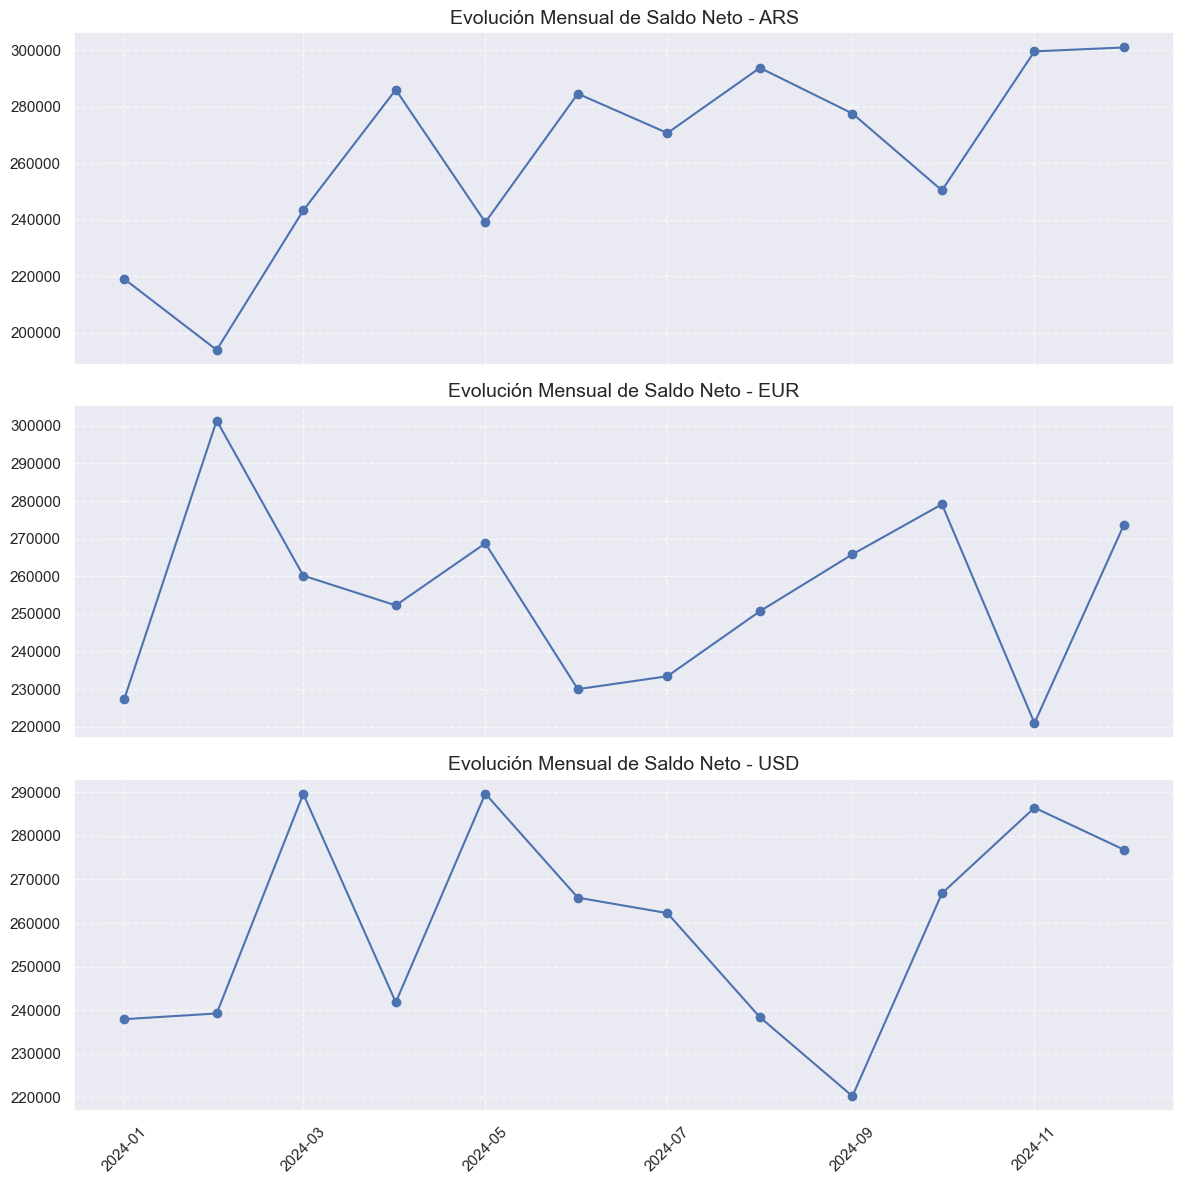

In [25]:
monedas = df_saldos['Moneda'].unique()

fig, axes = plt.subplots(nrows=len(monedas), ncols=1, figsize=(12, 4 * len(monedas)), sharex=True)

for ax, moneda in zip(axes, monedas):
    datos_moneda = df_saldos[df_saldos['Moneda'] == moneda]
    ax.plot(datos_moneda['Fecha'], datos_moneda['Saldo_Neto'], marker='o')
    ax.set_title(f'Evolución Mensual de Saldo Neto - {moneda}', fontsize=14)
    
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()



Se podría unificar todos los saldos en una misma moneda para analizar la evolución total de ingresos y egresos. Asimismo, sería posible expresarlos en términos reales, ajustando los valores a precios de diciembre de 2024 o a la fecha actual, con el fin de obtener una visión más precisa del valor presente de los montos.

### Un gráfico de barras que muestre los ingresos y egresos totales por banco.

In [26]:
# Calcular ingresos y egresos por banco y moneda
df_banco = df.groupby(['Banco', 'Moneda', 'TipoMovimiento'])['Monto'].sum().unstack().reset_index()

# Renombrar columnas
df_banco.columns.name = None  # quitar nombre del índice
df_banco = df_banco.rename(columns={'Egreso': 'Egresos', 'Ingreso': 'Ingresos'})

# Asegurar que egresos sean positivos
df_banco['Egresos'] = df_banco['Egresos'].abs()

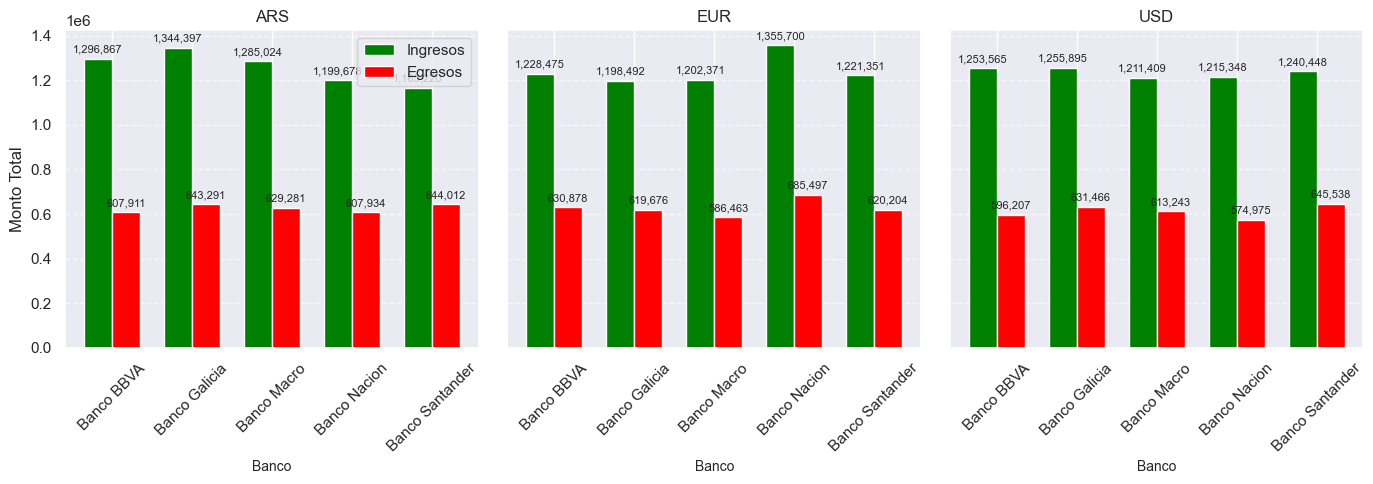

In [27]:
monedas = df_banco['Moneda'].unique()
ancho = 0.35
x = np.arange(len(df_banco['Banco'].unique()))

fig, axs = plt.subplots(1, len(monedas), figsize=(14, 5), sharey=True)

for i, moneda in enumerate(monedas):
    df_moneda = df_banco[df_banco['Moneda'] == moneda]
    bancos = df_moneda['Banco']
    ingresos = df_moneda['Ingresos']
    egresos = df_moneda['Egresos']

    b1 = axs[i].bar(x - ancho/2, ingresos, ancho, label='Ingresos', color='green')
    b2 = axs[i].bar(x + ancho/2, egresos, ancho, label='Egresos', color='red')

    axs[i].set_title(f'{moneda}', fontsize=12)
    axs[i].set_xlabel('Banco', fontsize=10)
    axs[i].set_xticks(x)
    axs[i].set_xticklabels(bancos, rotation=45)
    axs[i].grid(axis='y', linestyle='--', alpha=0.7)

    # Anotar valores
    for bar in [b1, b2]:
        for rect in bar:
            height = rect.get_height()
            axs[i].annotate(f'{height:,.0f}',
                            xy=(rect.get_x() + rect.get_width() / 2, height),
                            xytext=(0, 3),
                            textcoords="offset points",
                            ha='center', va='bottom', fontsize=8)

axs[0].set_ylabel('Monto Total')
axs[0].legend()
plt.tight_layout()
plt.show()

### Un gráfico de barras que muestre los ingresos y egresos totales por banco para todo el año.

In [28]:
# Calcular ingresos y egresos mensuales por banco y moneda
df_evolucion = df.groupby(['Banco', 'Mes', 'Moneda', 'TipoMovimiento'])['Monto'].sum().unstack(fill_value=0).reset_index()

# Renombrar columnas
df_evolucion = df_evolucion.rename(columns={'Egreso': 'Egresos', 'Ingreso': 'Ingresos'})

# Convertir egresos a positivo
df_evolucion['Egresos'] = df_evolucion['Egresos'].abs()

# Calcular saldo neto
df_evolucion['SaldoNeto'] = df_evolucion['Ingresos'] - df_evolucion['Egresos']

# Ordenar meses
df_evolucion['Mes'] = df_evolucion['Mes'].astype(int)
df_evolucion = df_evolucion.sort_values(['Banco', 'Moneda', 'Mes'])

# Listas únicas de bancos y monedas
bancos = df_evolucion['Banco'].unique()
monedas = df_evolucion['Moneda'].unique()

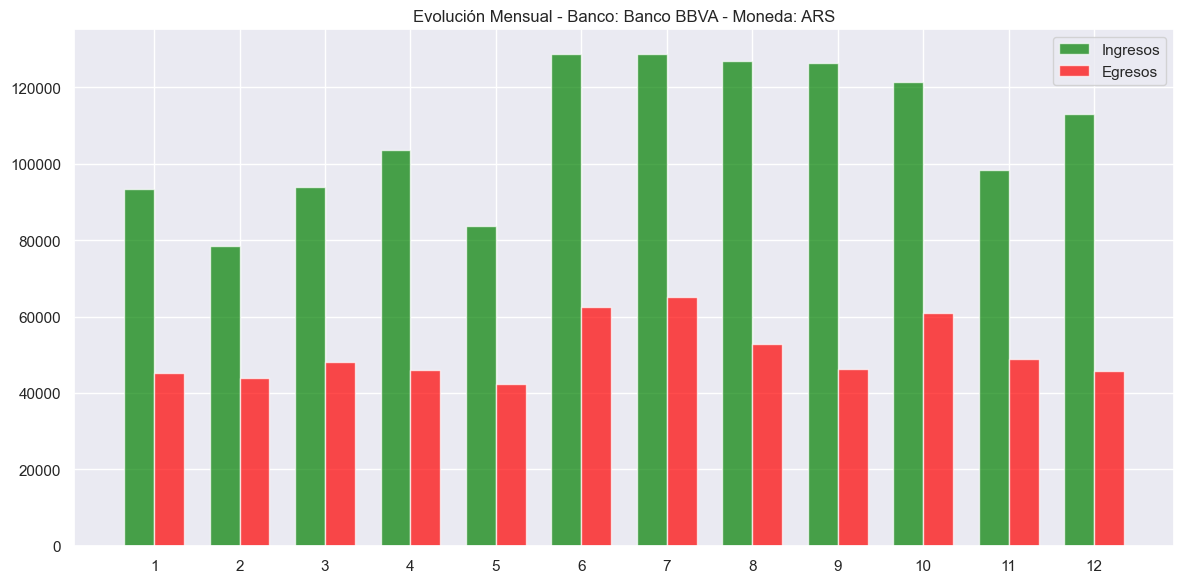

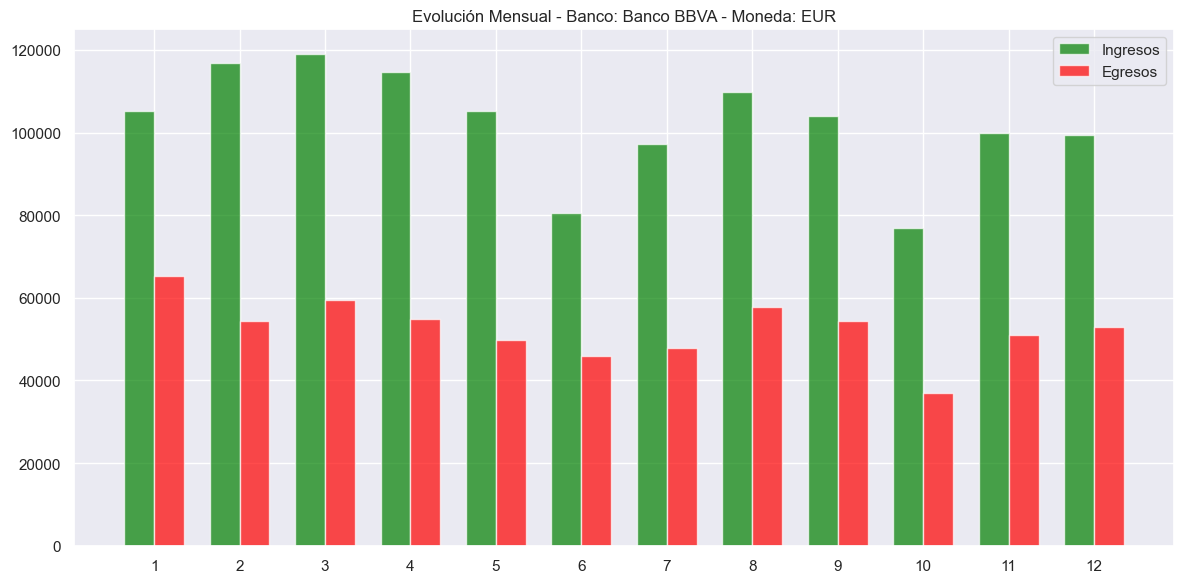

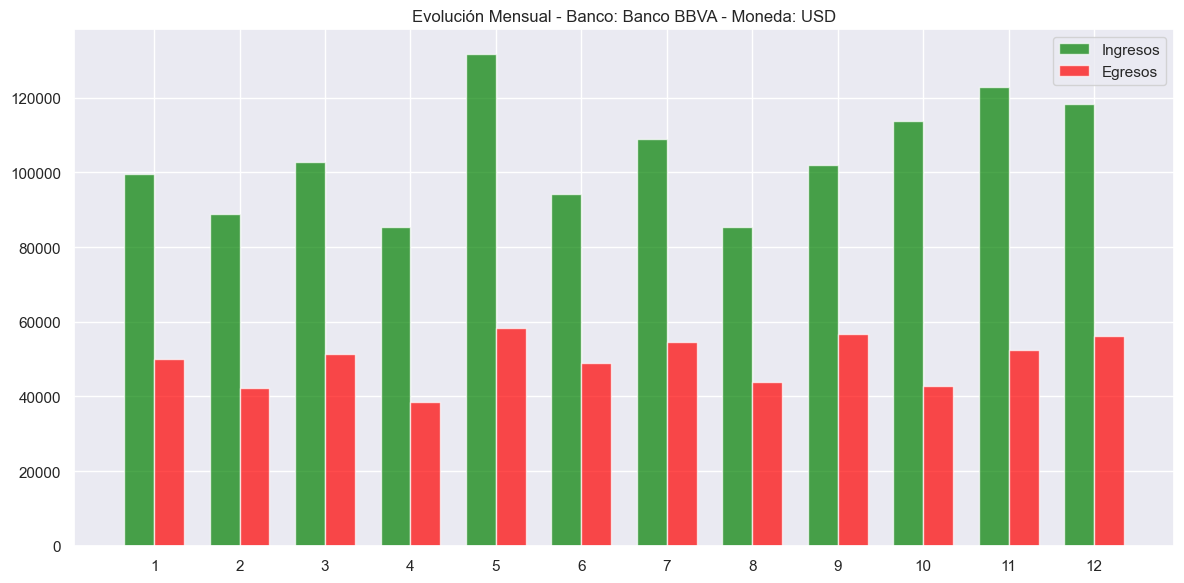

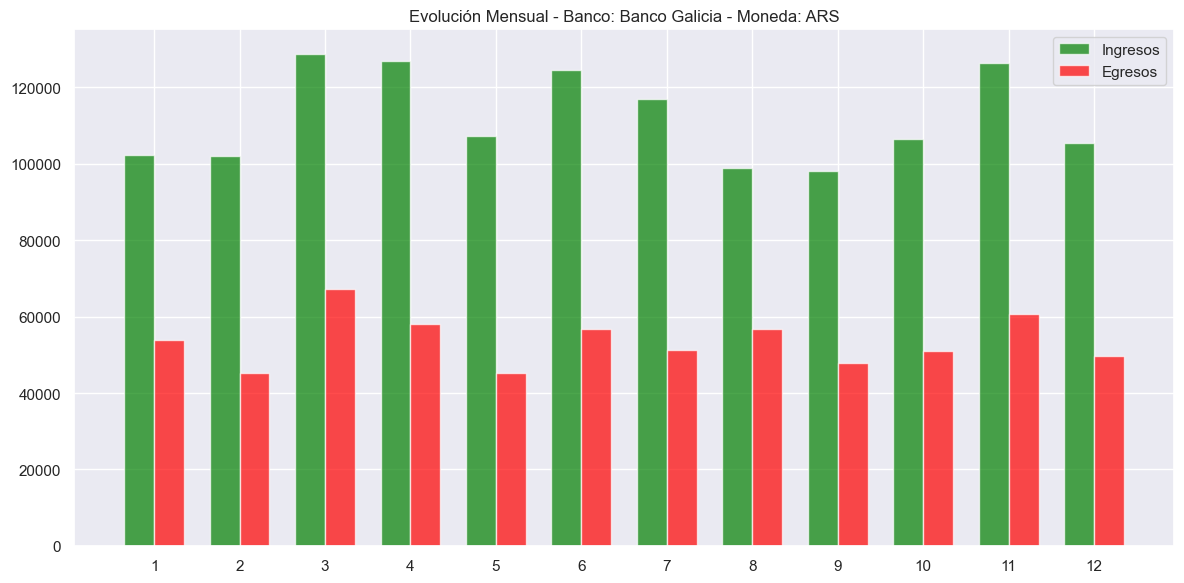

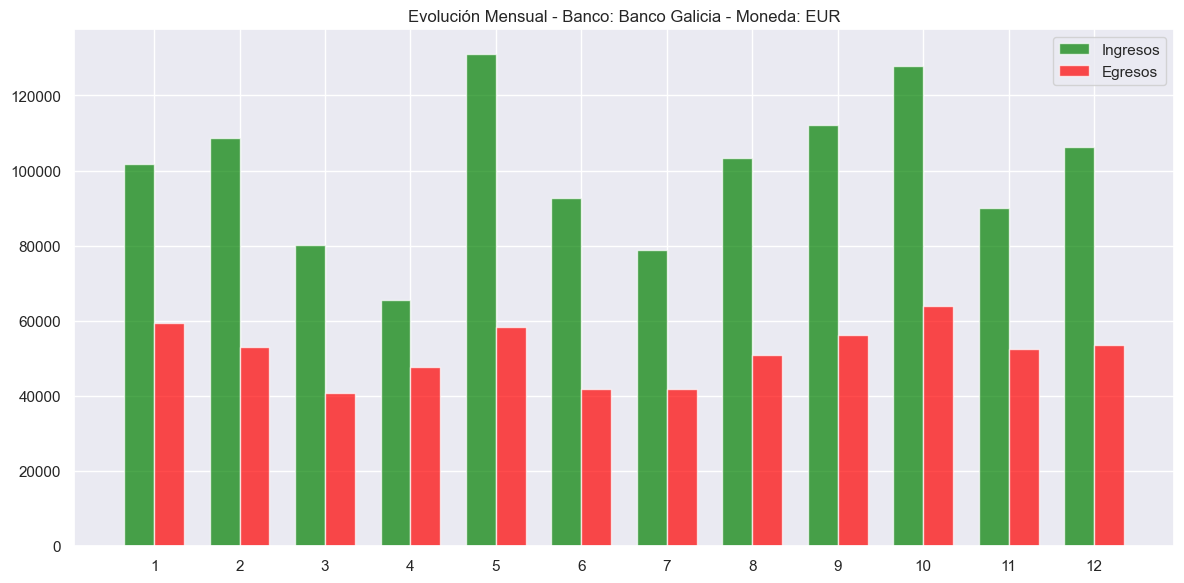

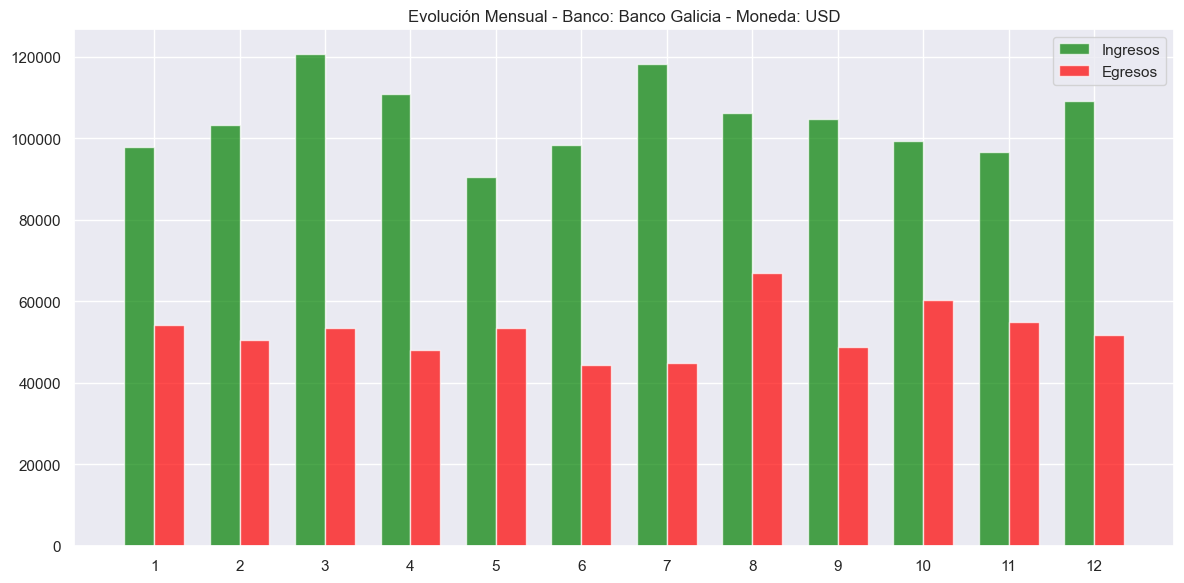

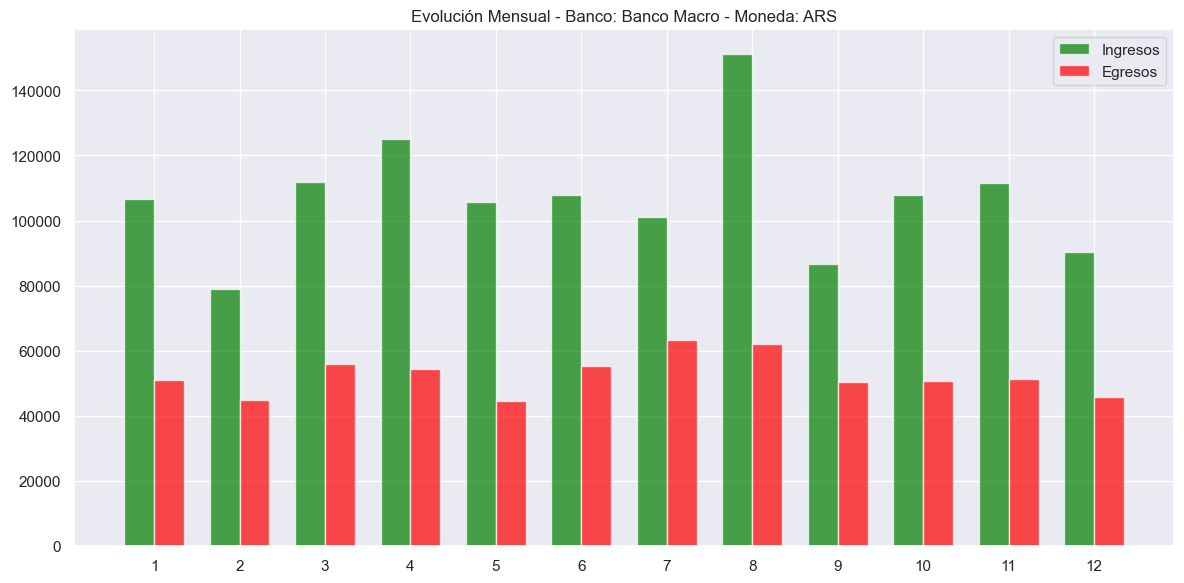

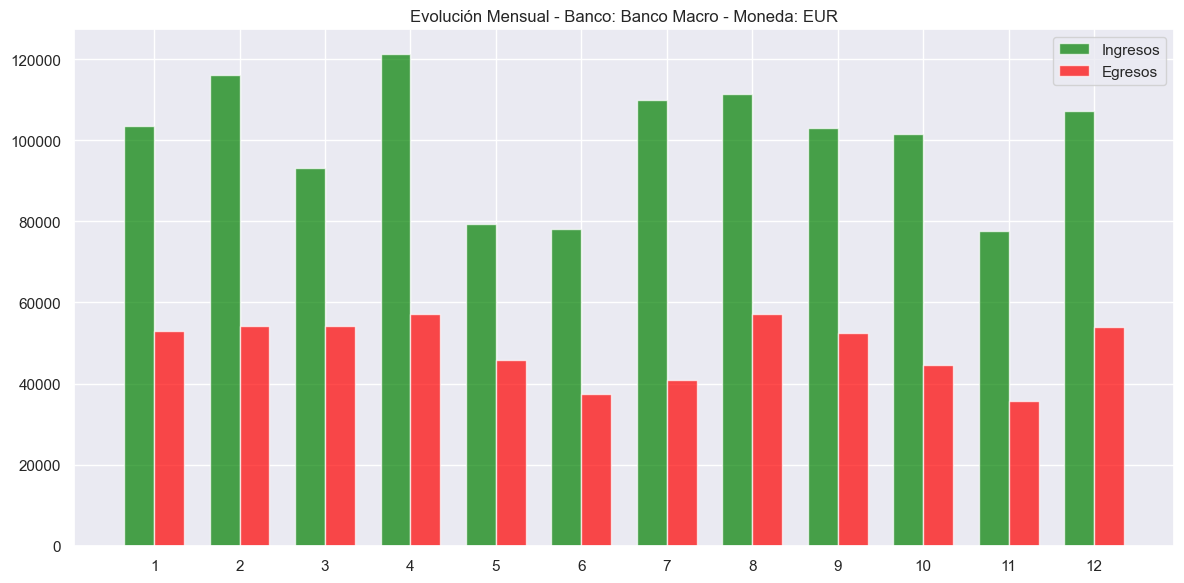

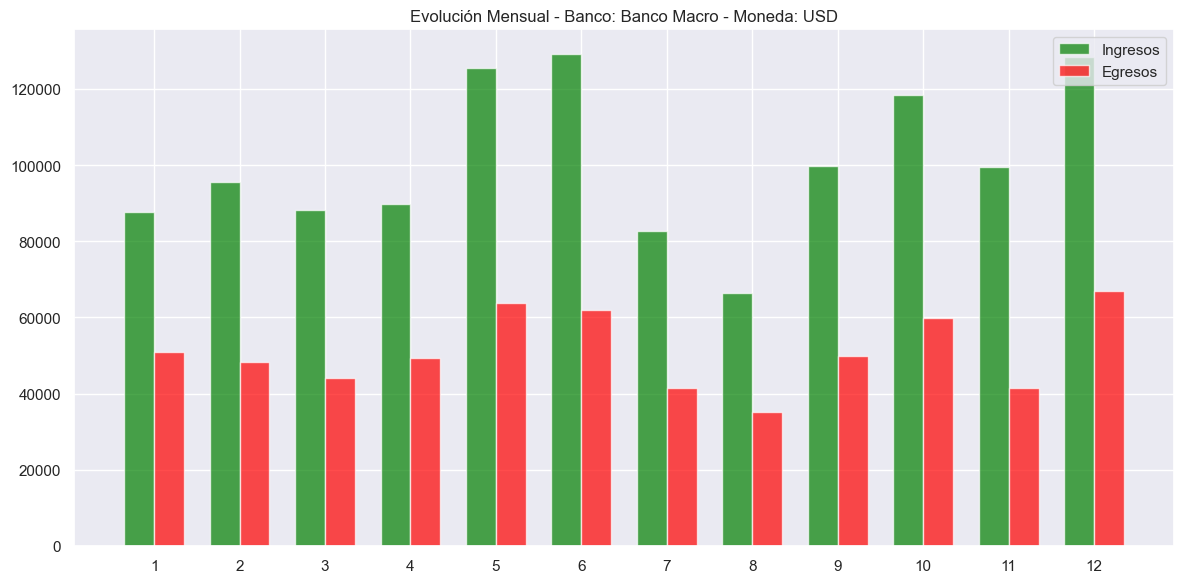

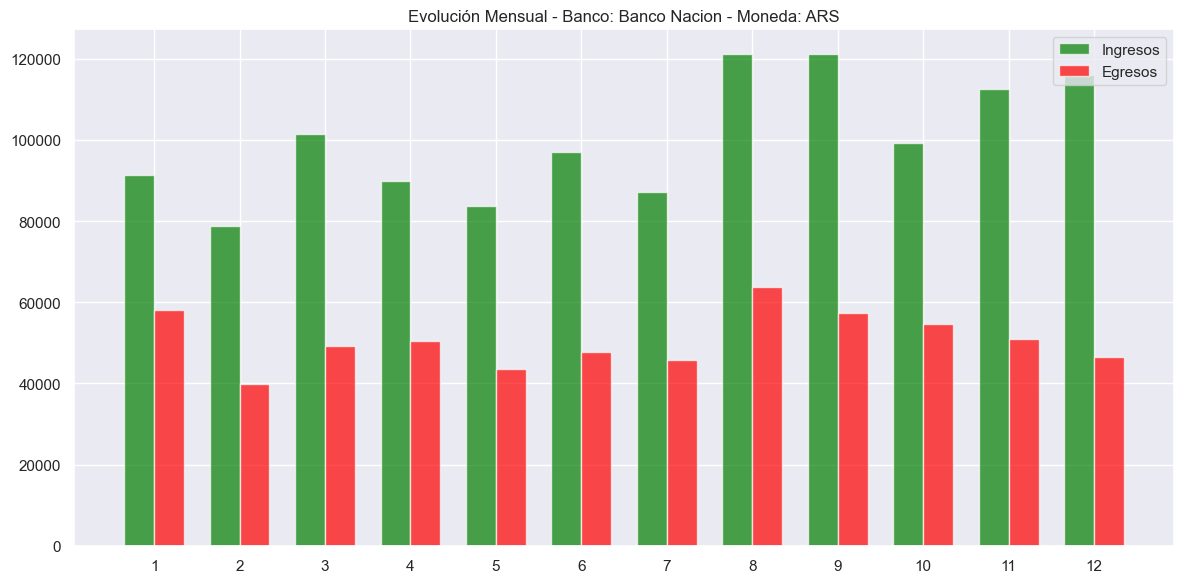

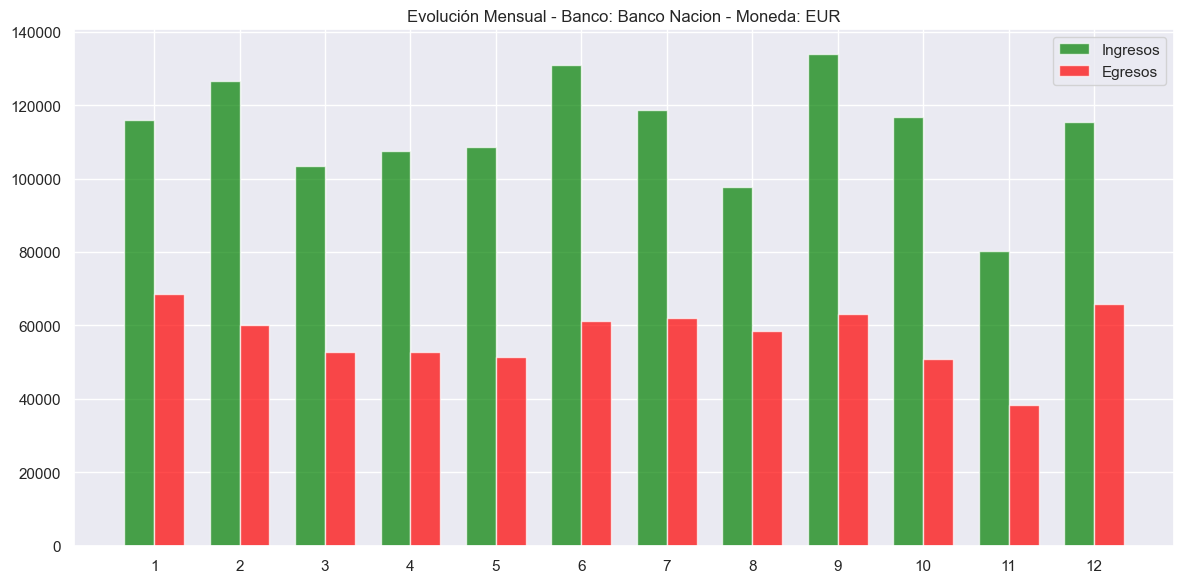

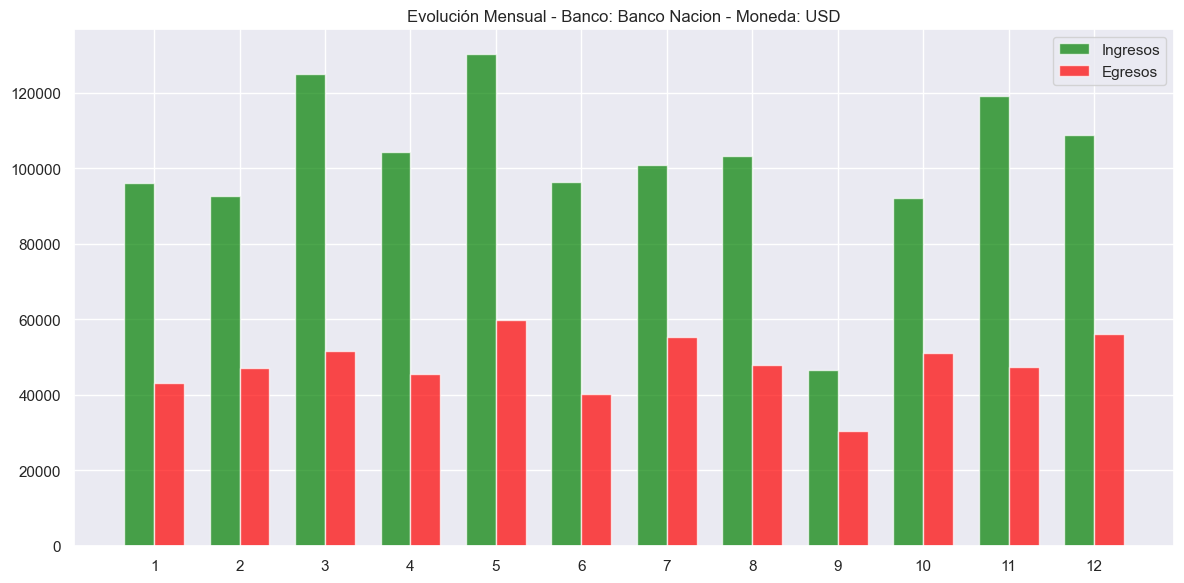

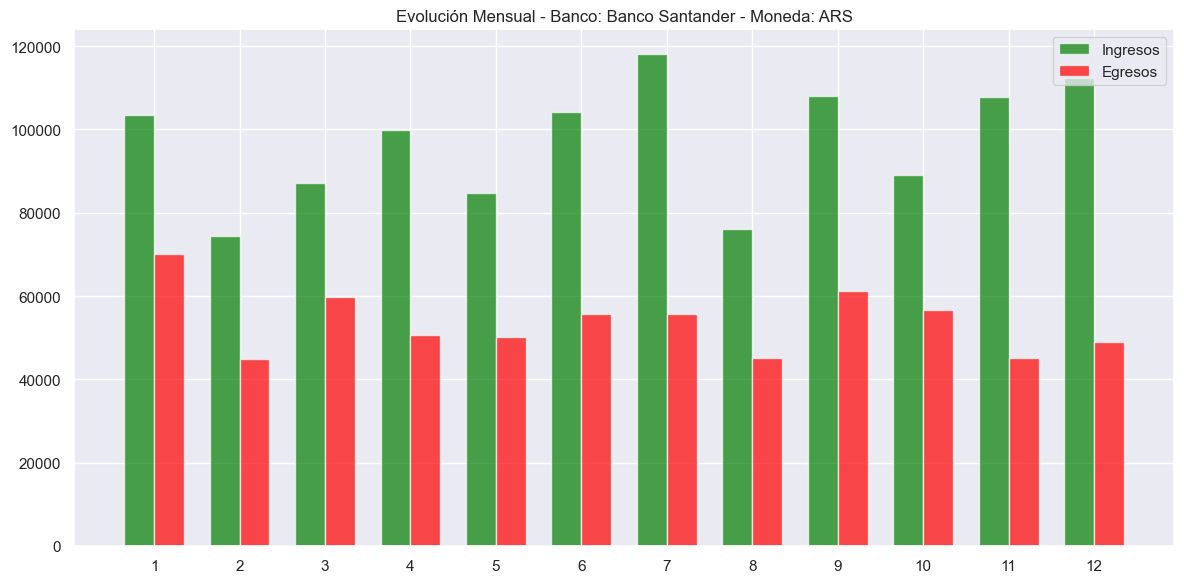

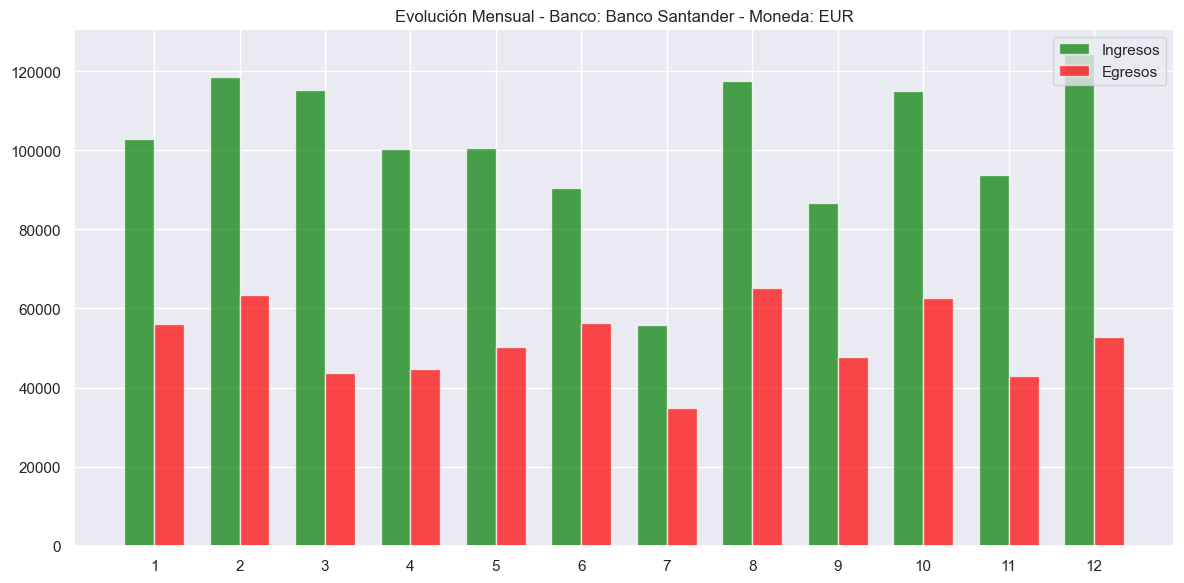

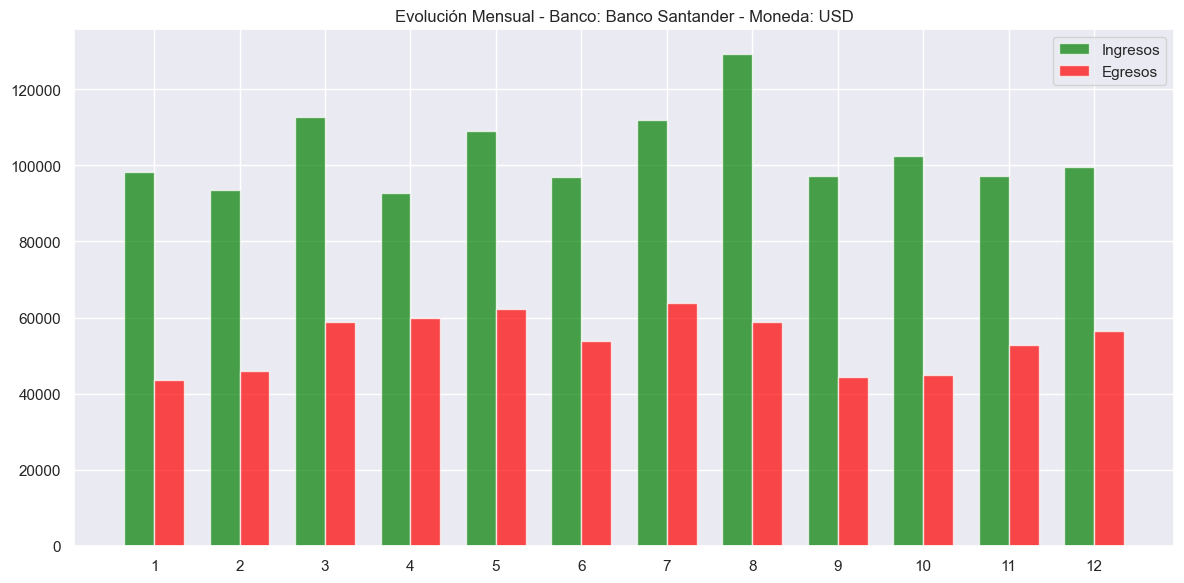

In [29]:
for banco in bancos:
    for moneda in monedas:
        df_filtrado = df_evolucion[(df_evolucion['Banco'] == banco) & (df_evolucion['Moneda'] == moneda)]
        
        fig, ax1 = plt.subplots(figsize=(12, 6))
        
        posiciones = range(len(df_filtrado))
        ancho = 0.35
        
        ax1.bar([p - ancho/2 for p in posiciones], df_filtrado['Ingresos'], 
                width=ancho, label='Ingresos', color='green', alpha=0.7)
        ax1.bar([p + ancho/2 for p in posiciones], df_filtrado['Egresos'], 
                width=ancho, label='Egresos', color='red', alpha=0.7)
        
        ax1.set_xticks(posiciones)
        ax1.set_xticklabels(df_filtrado['Mes'])
        ax1.tick_params(axis='y')
        
        plt.title(f'Evolución Mensual - Banco: {banco} - Moneda: {moneda}')
        fig.legend(loc='upper right', bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
        
        plt.tight_layout()
        plt.show()

El análisis muestra un flujo entre ingresos y egresos estable con saldo constante positivo. Para simplificar la cantidad de gráficos podria pasar todo a una sola moneda y ver los saldos totales. Habria que ver cual era el tipo de cambio para cada uno de los meses. 

### Exportar a Excel

In [30]:
# df.to_excel("Base_test_MELI.xlsx", index=False)

### Anexo - Realizo un analisis mes a mes visual de Ingresos y Egresos por Moneda

<Figure size 1500x7200 with 0 Axes>

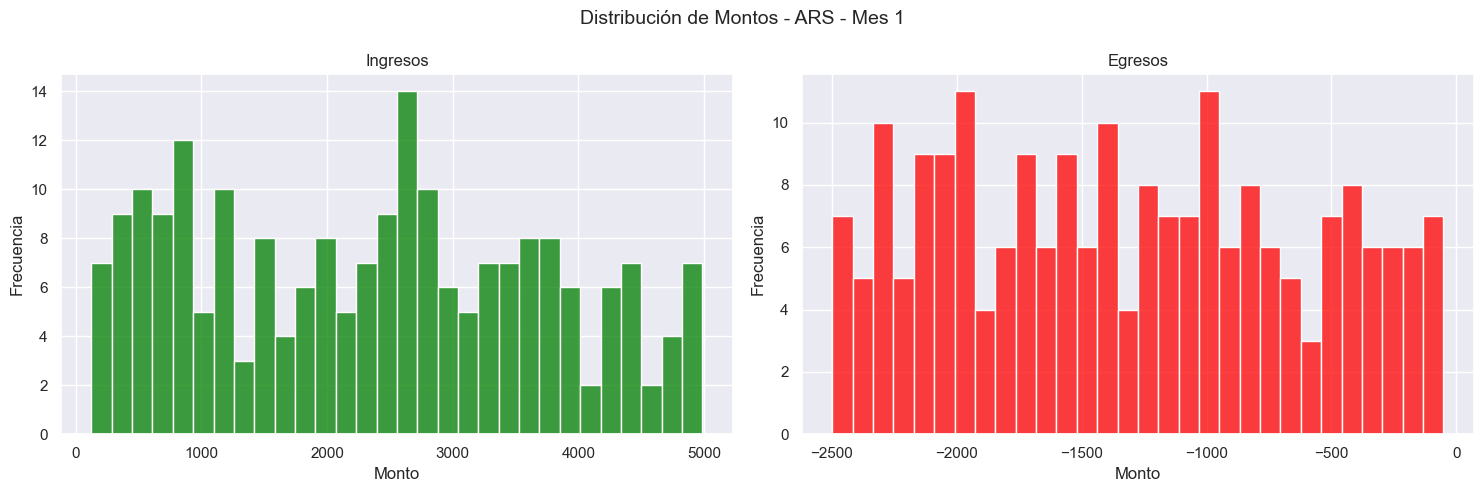

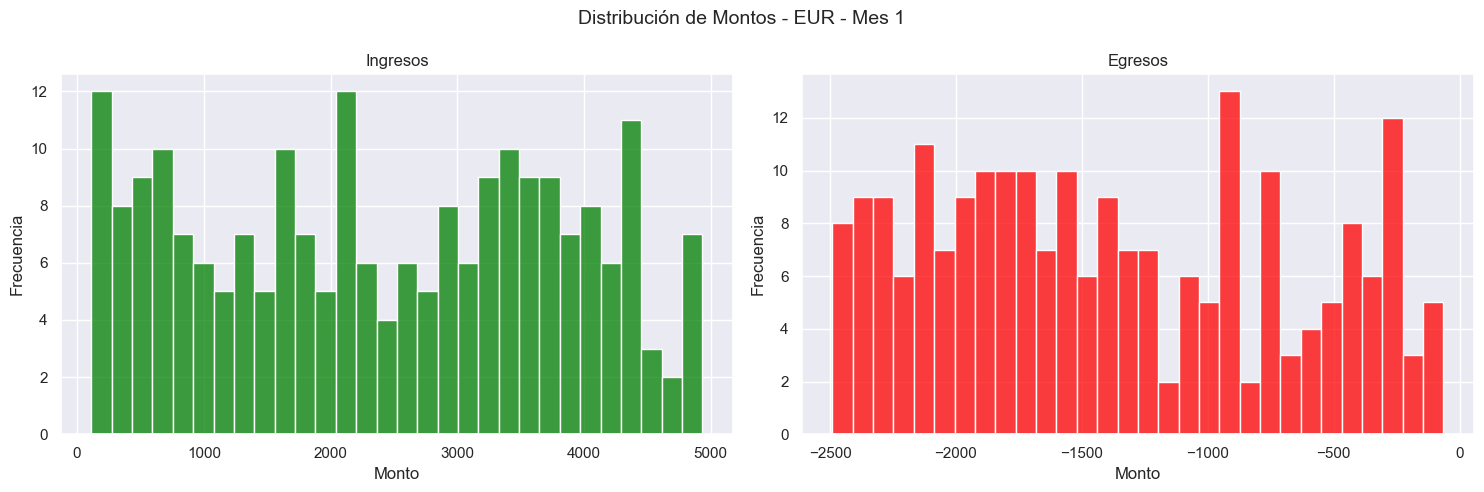

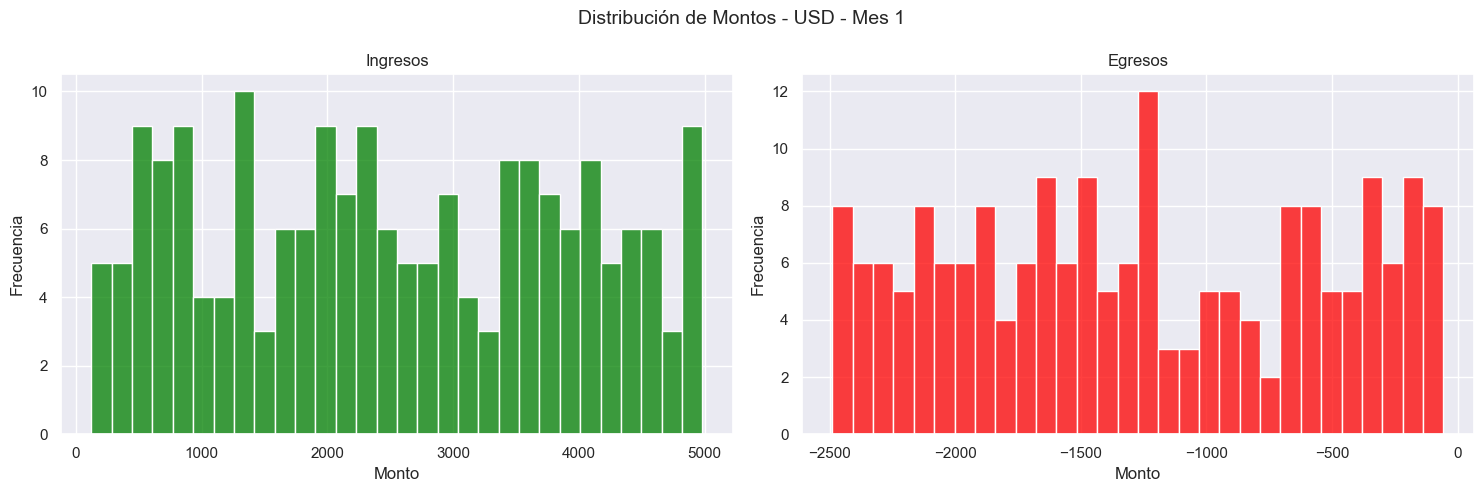

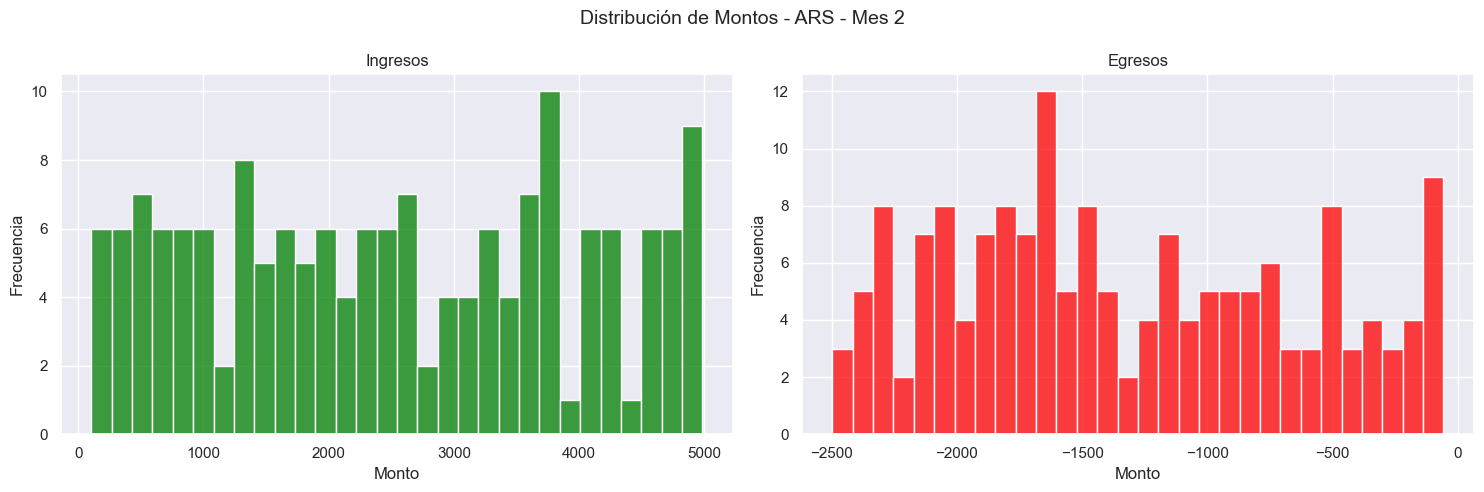

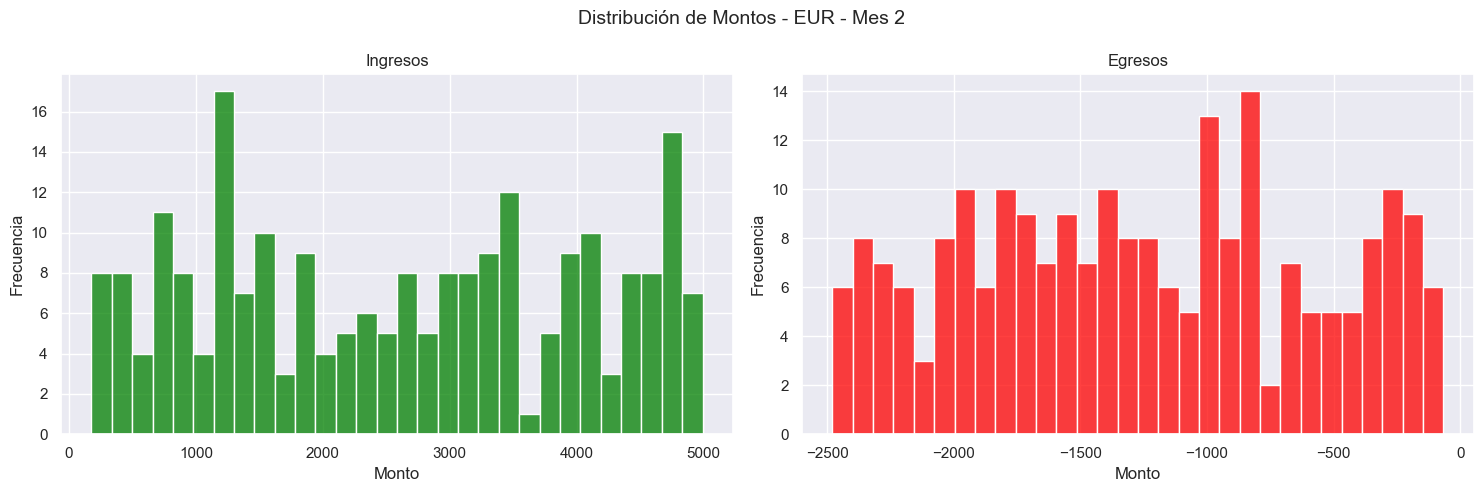

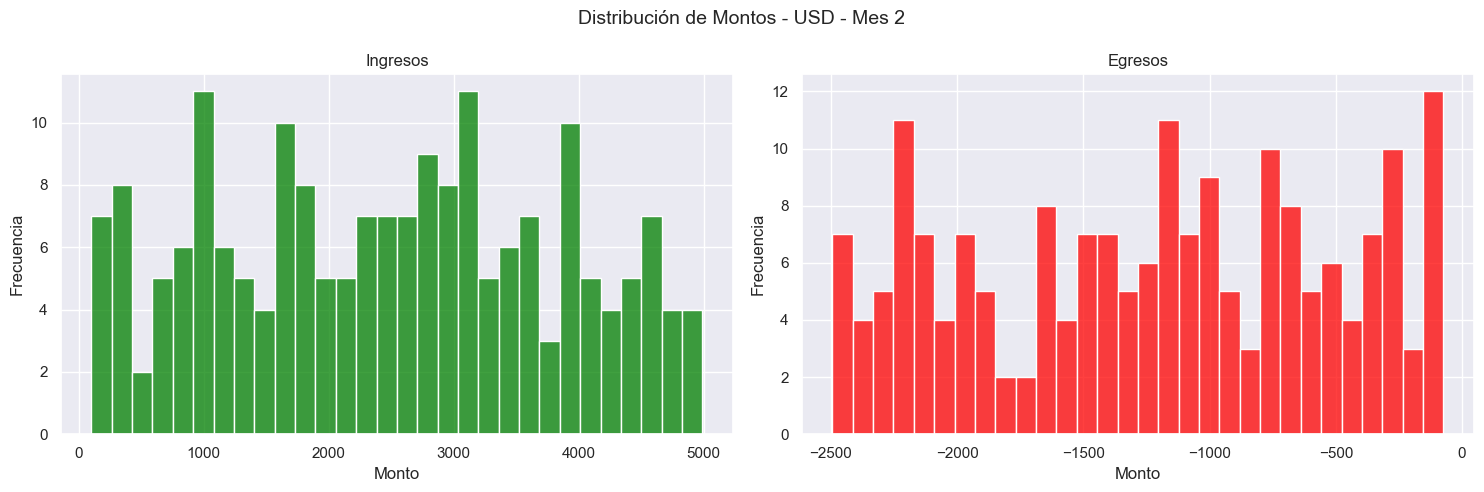

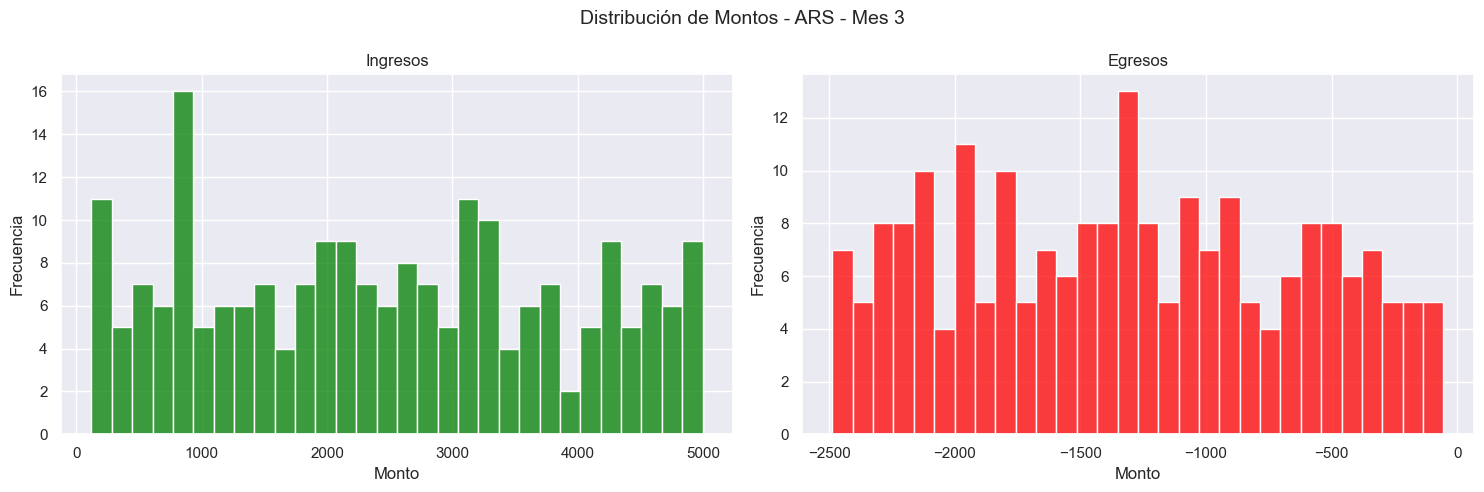

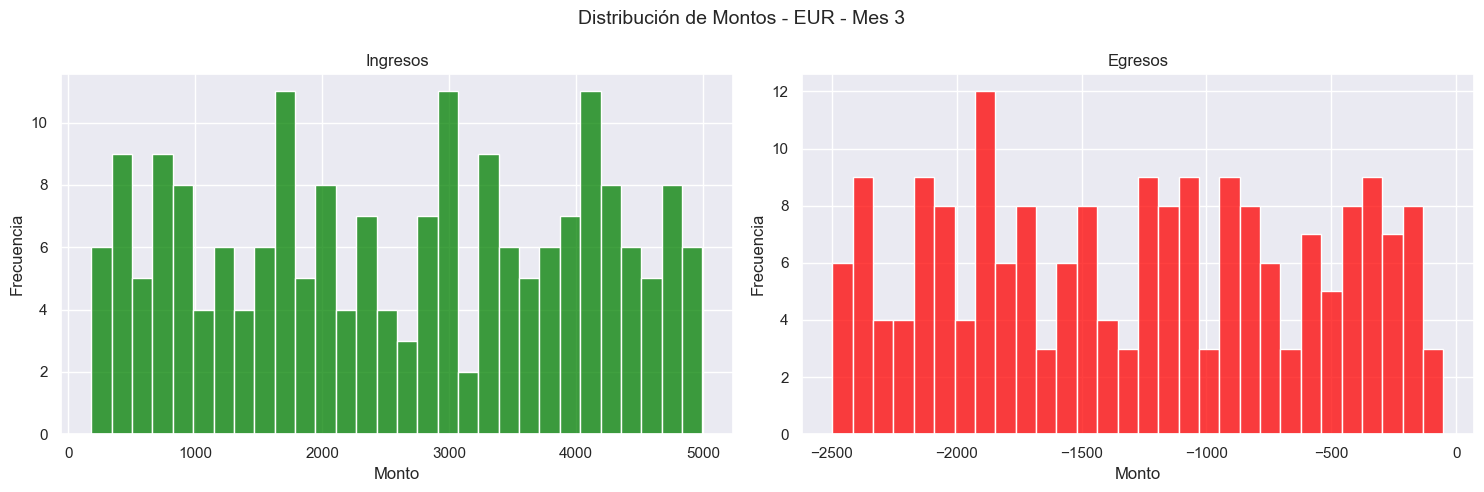

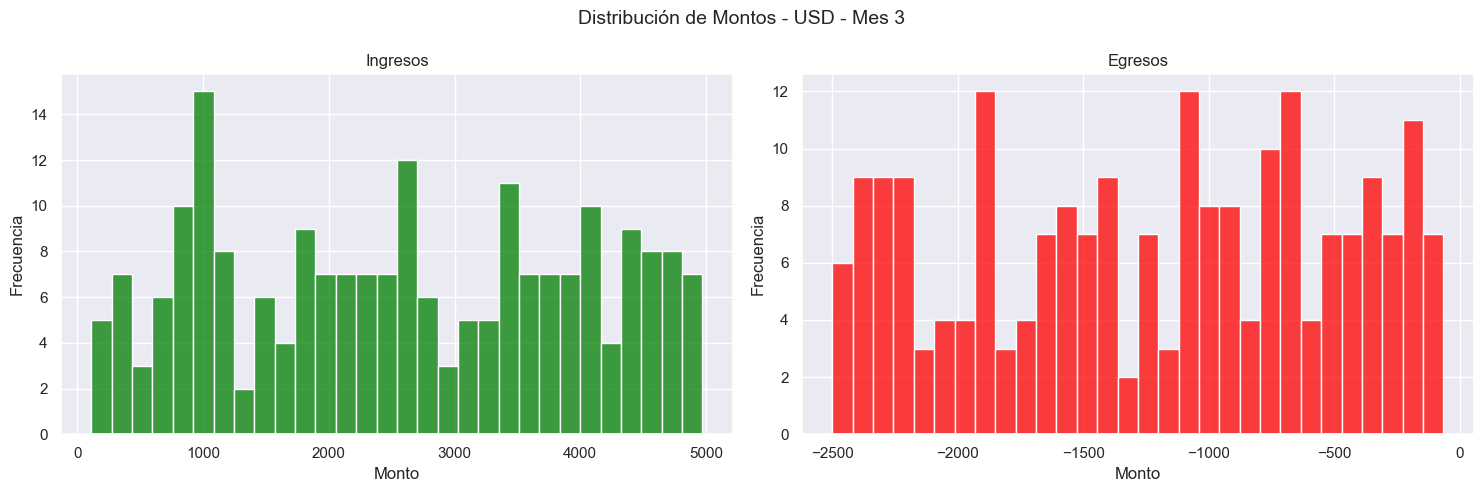

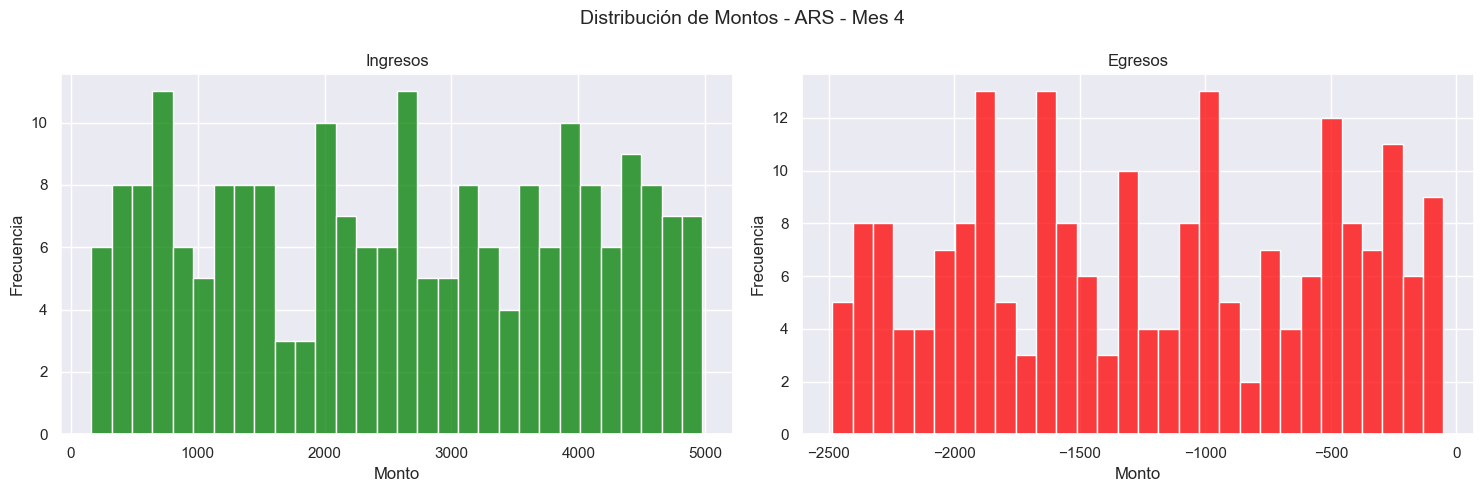

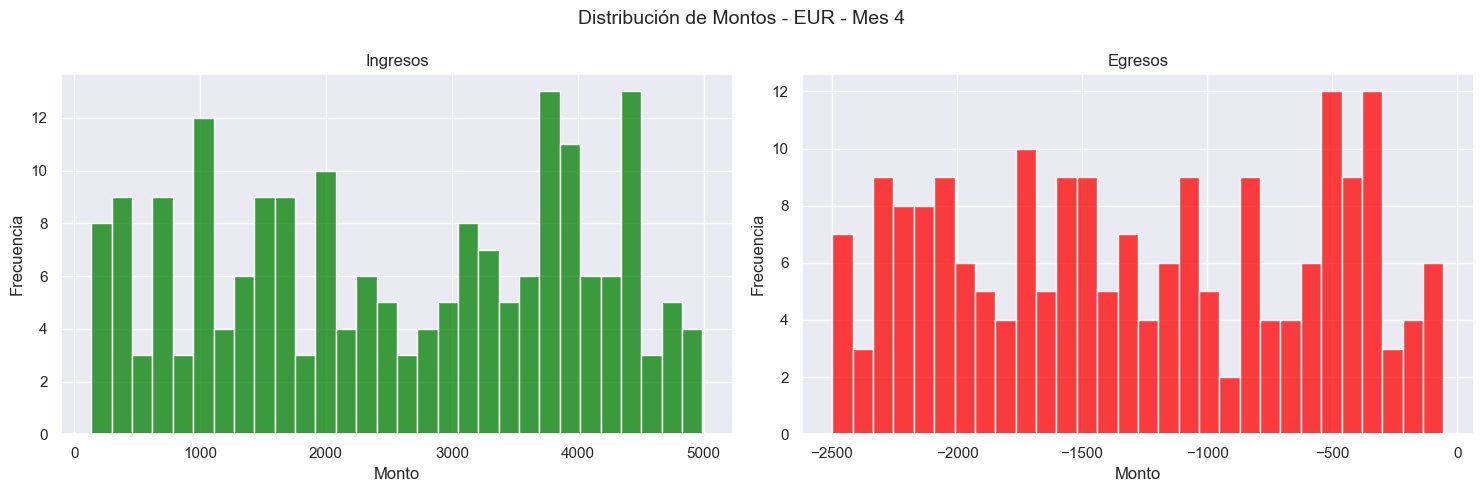

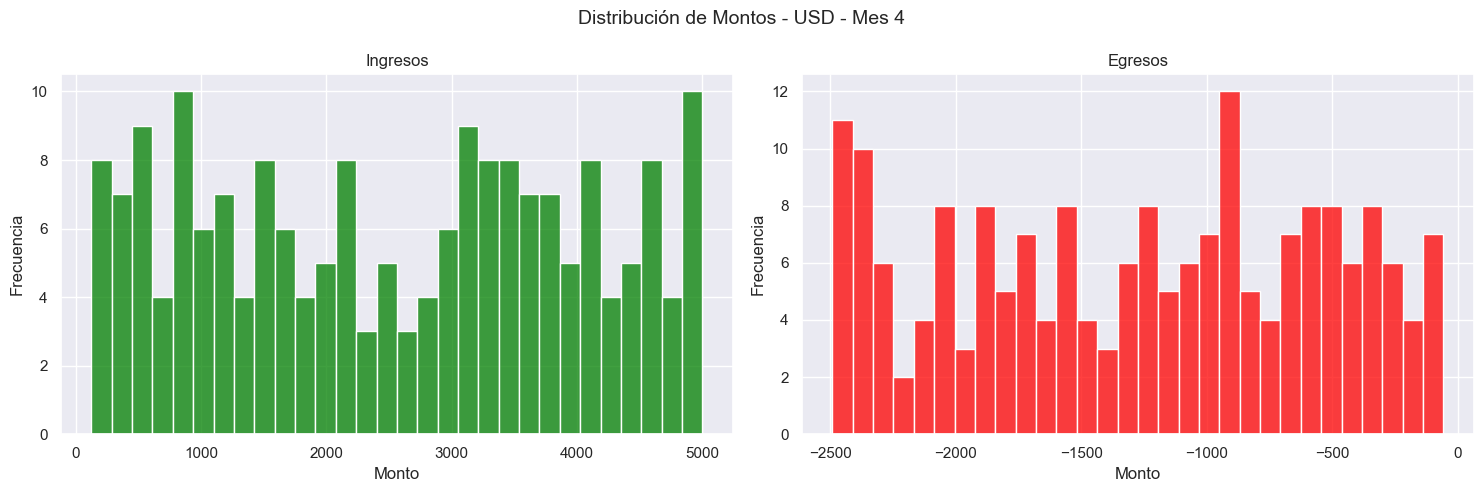

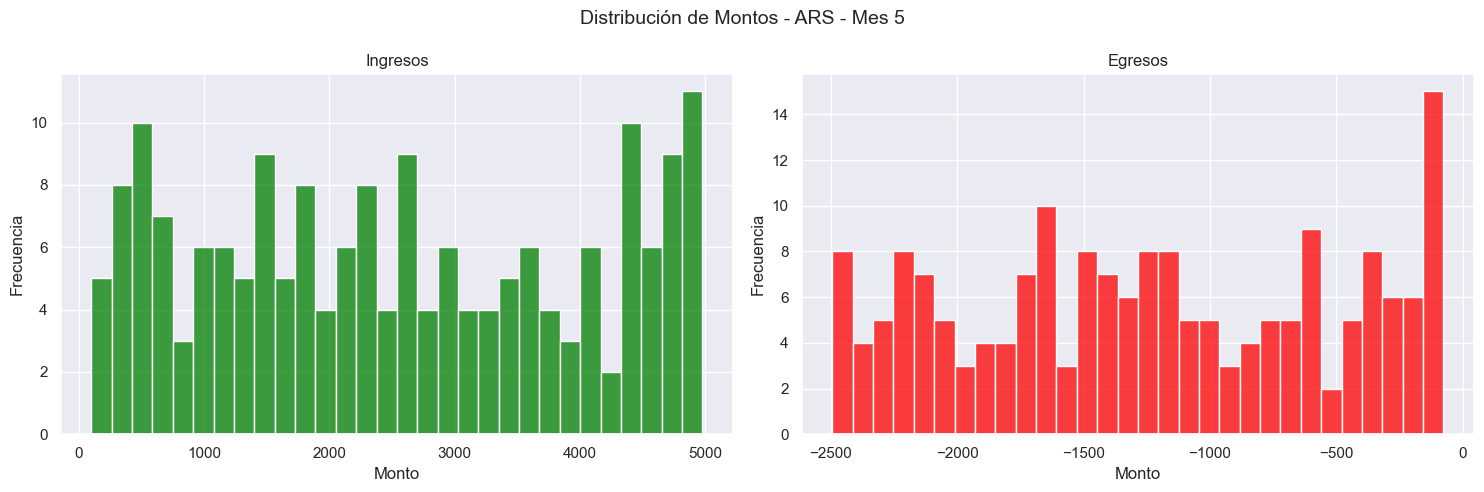

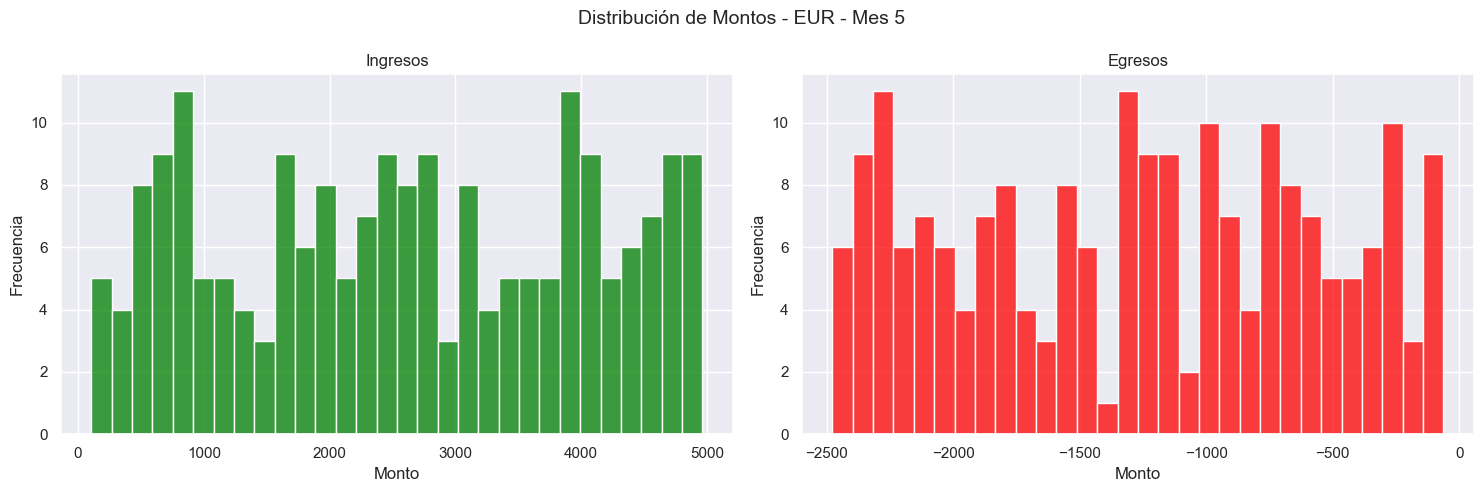

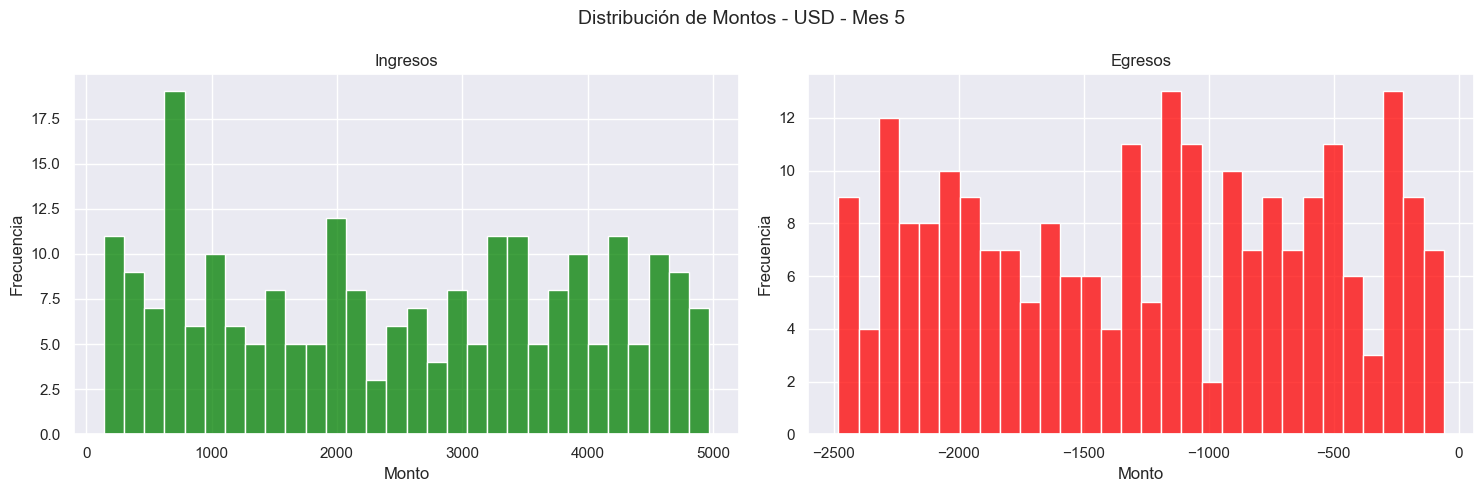

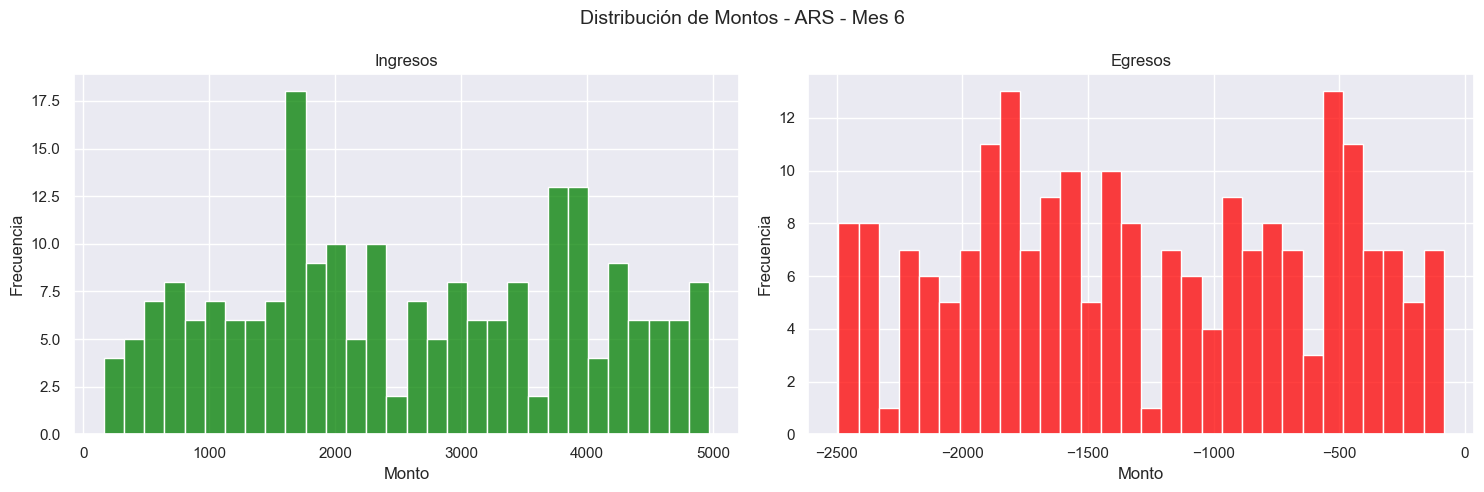

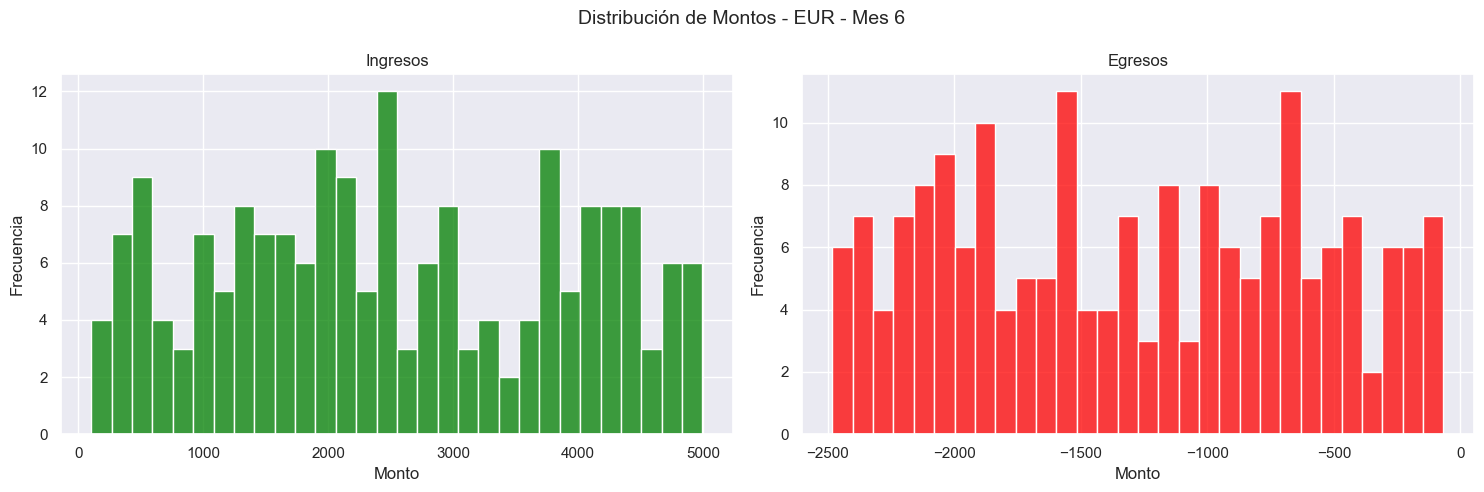

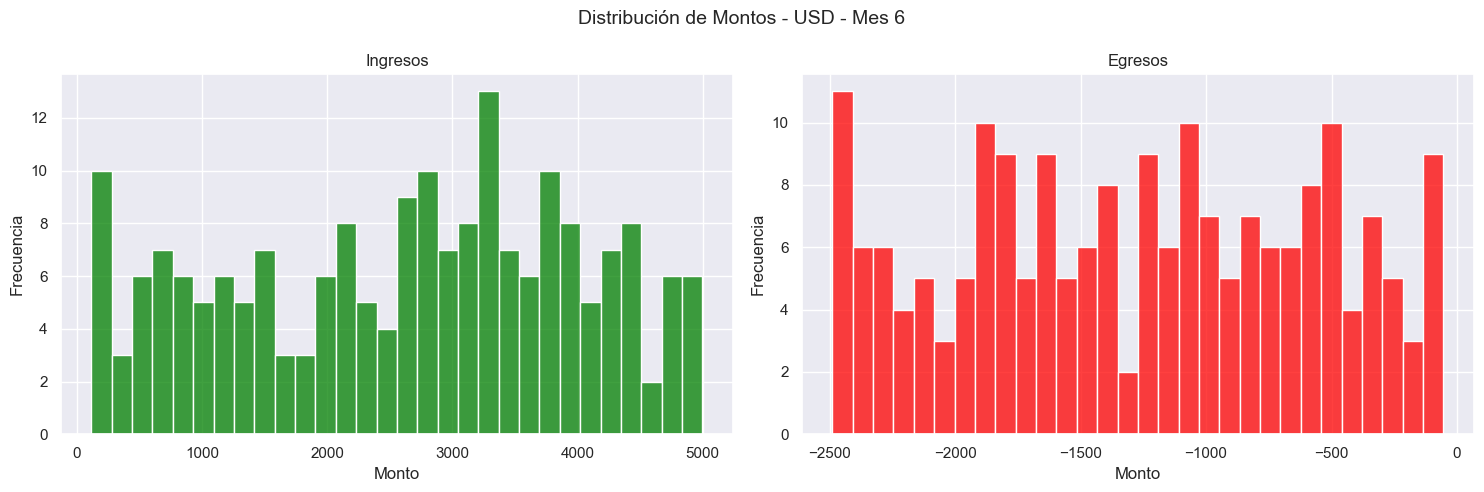

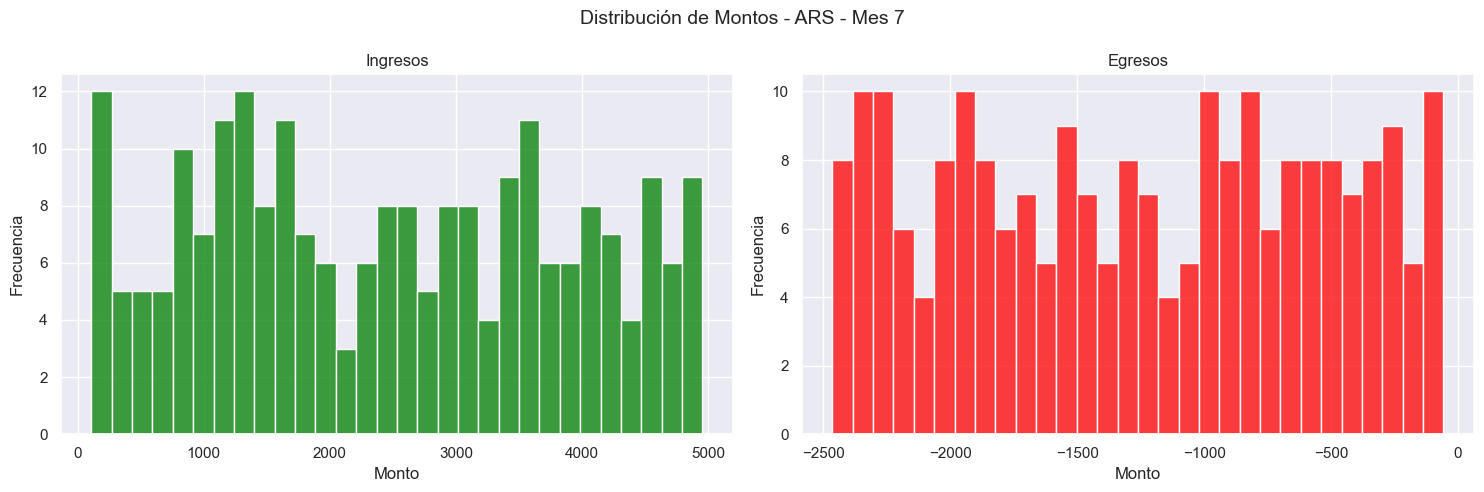

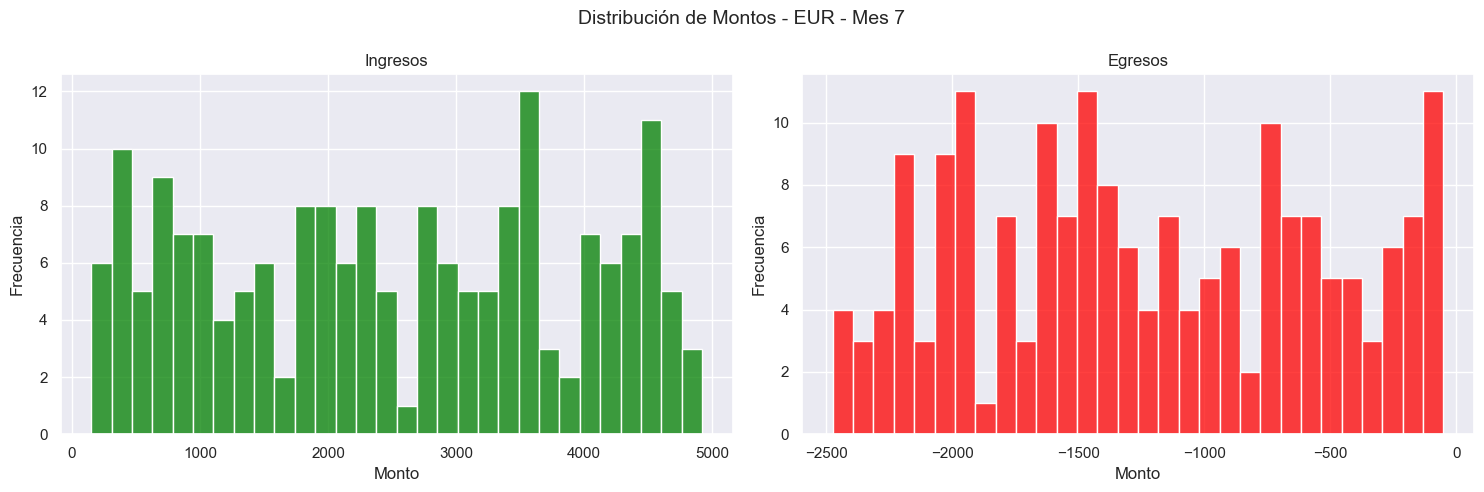

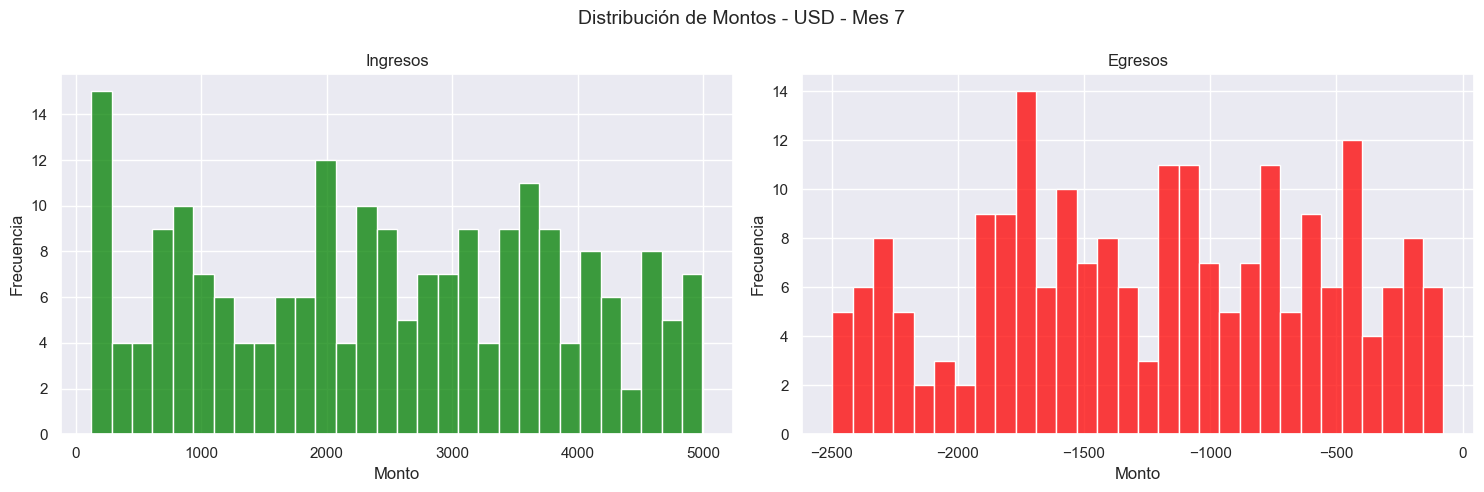

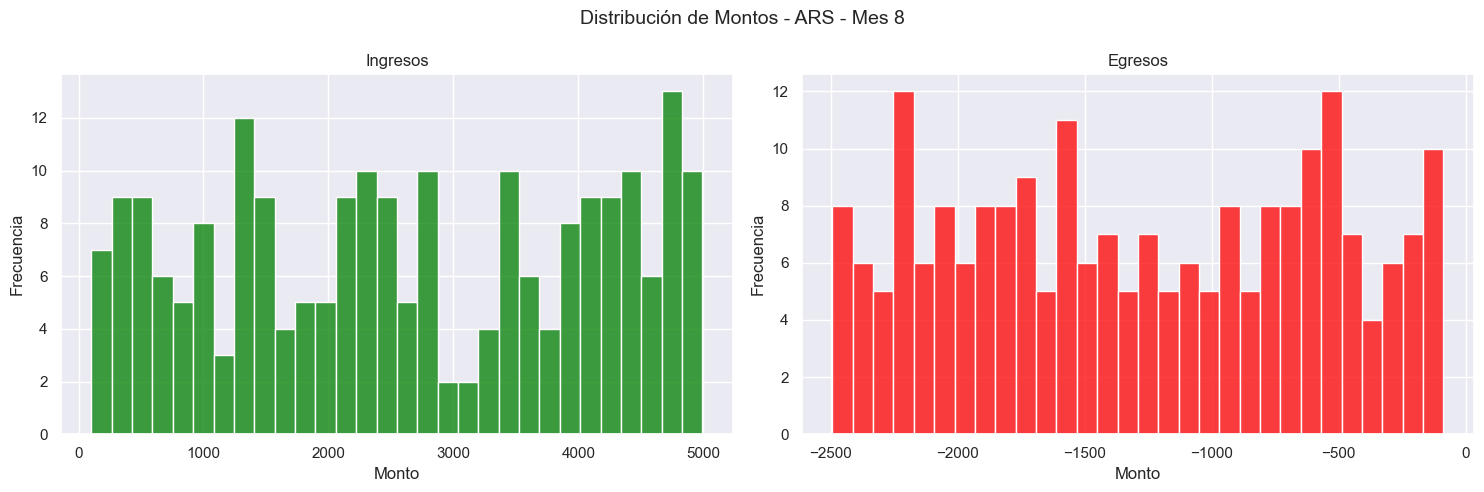

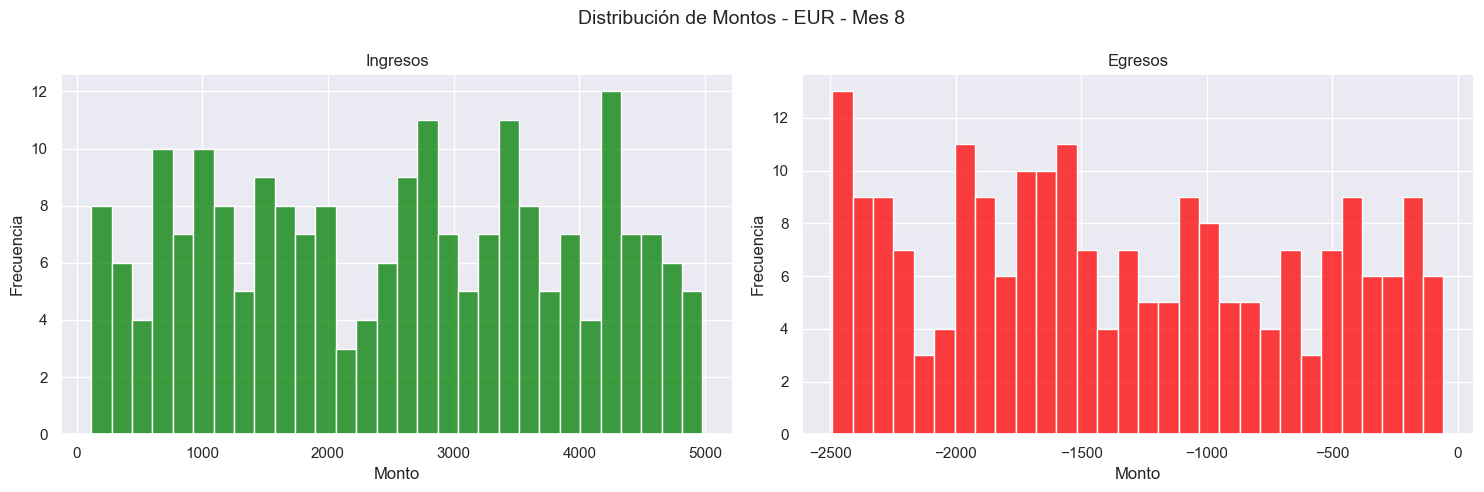

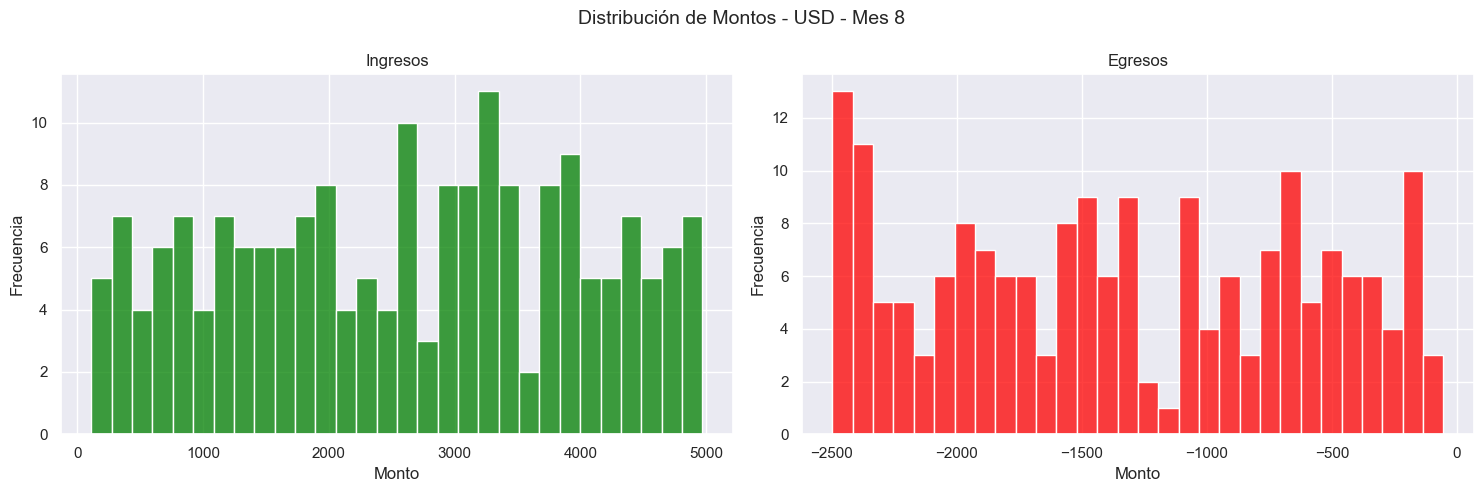

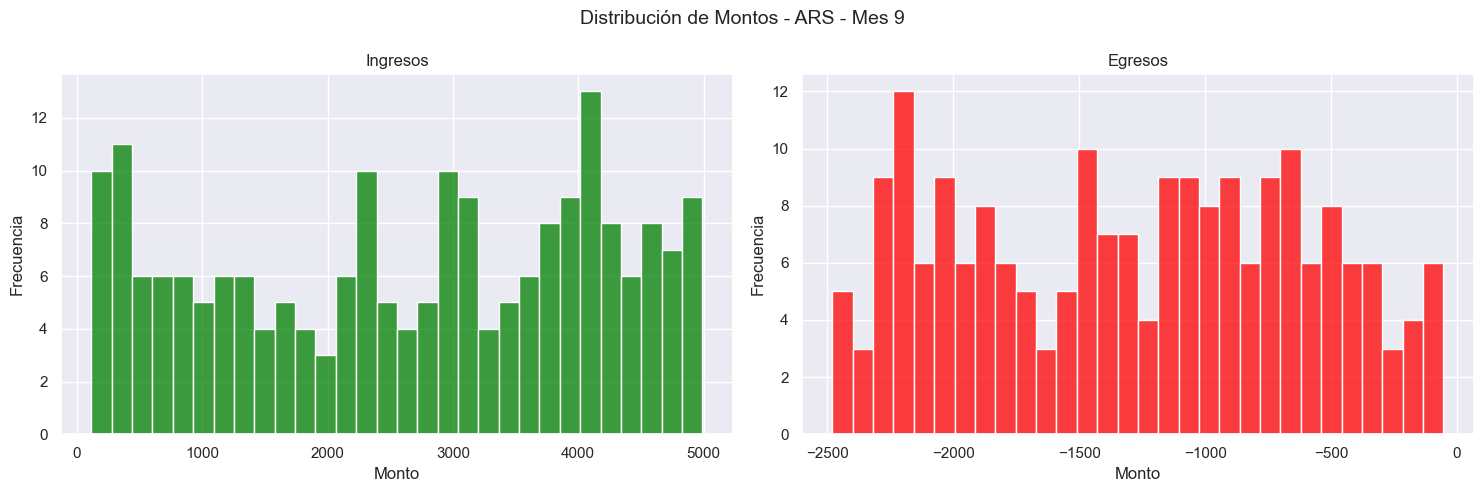

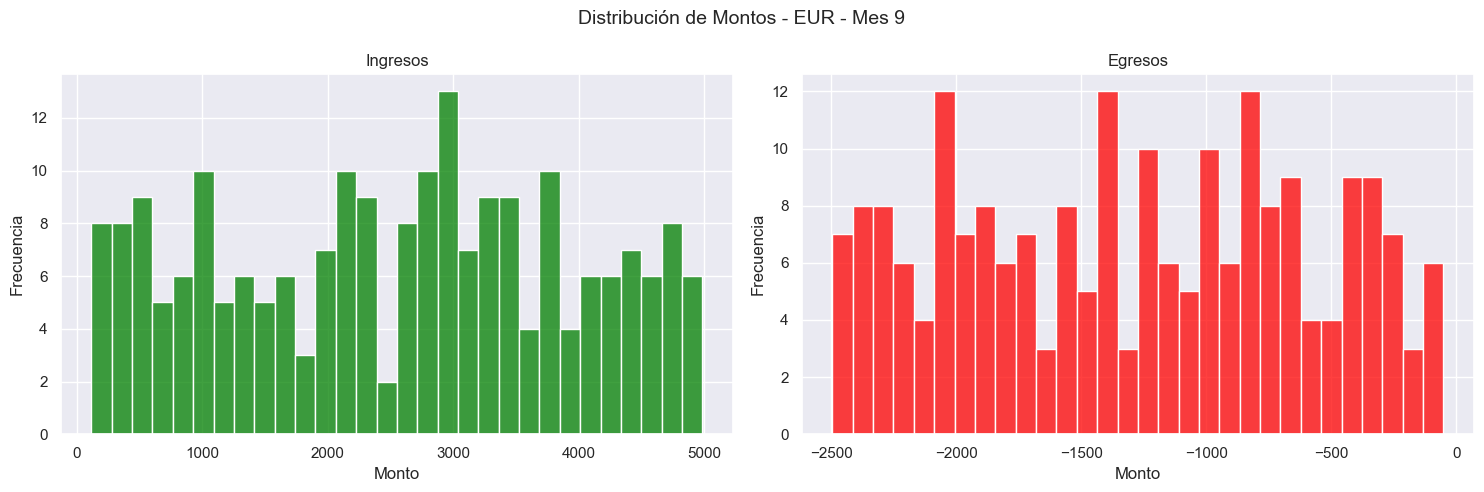

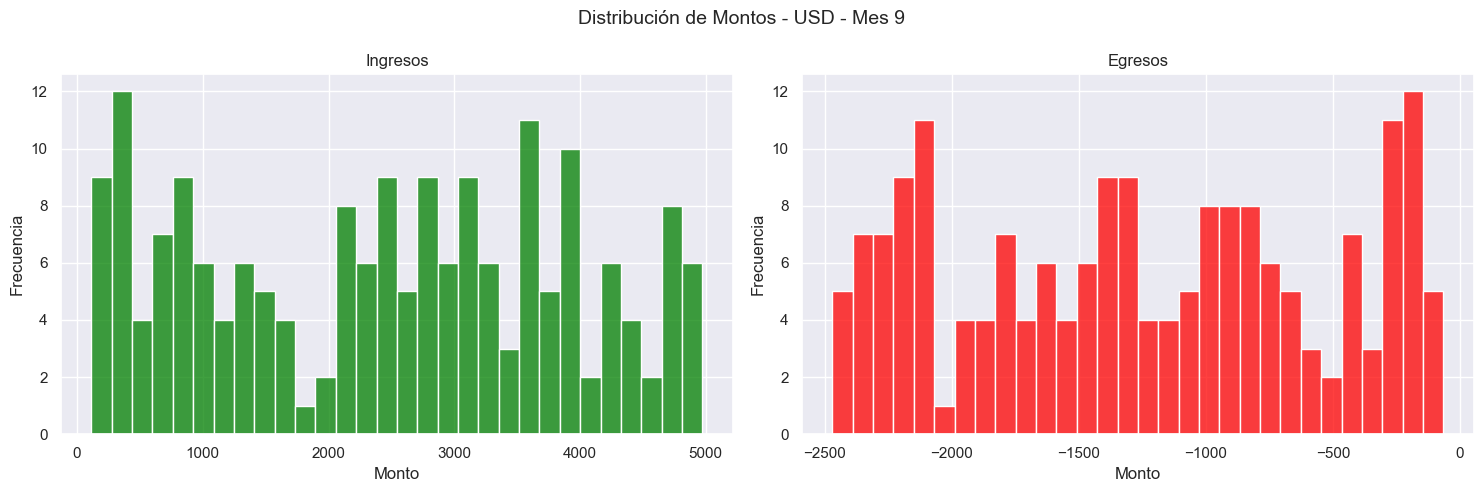

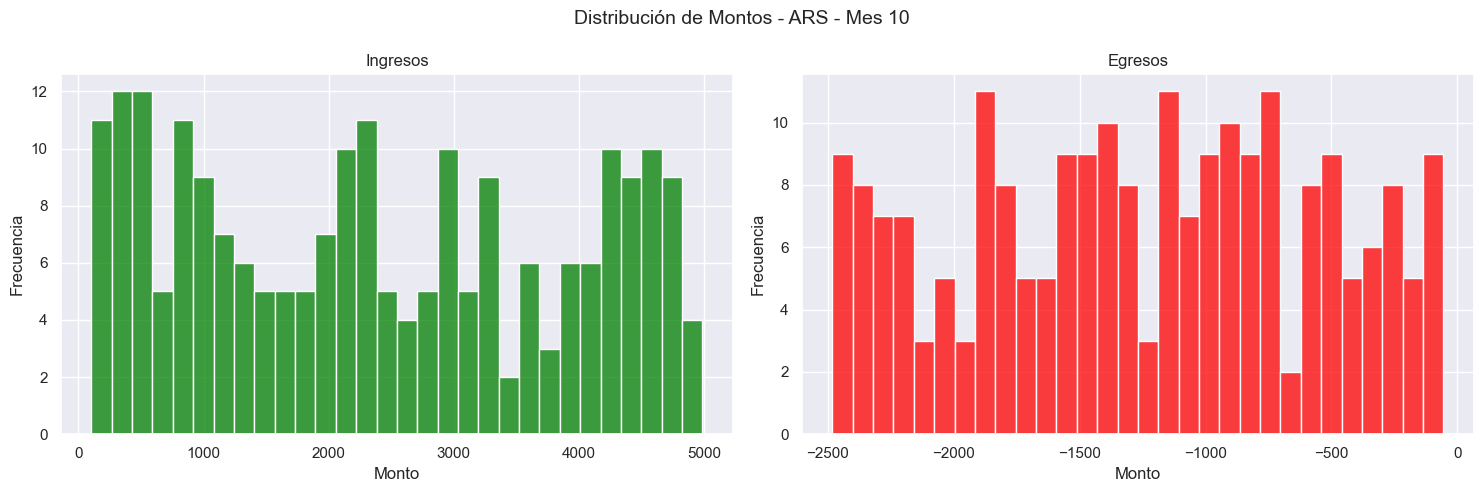

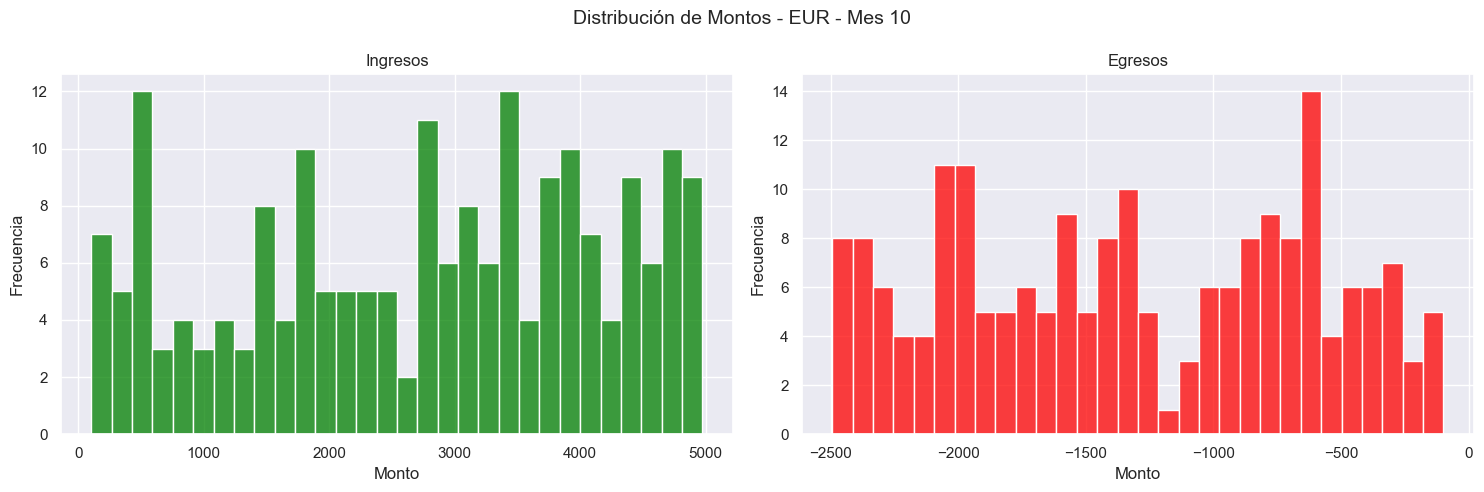

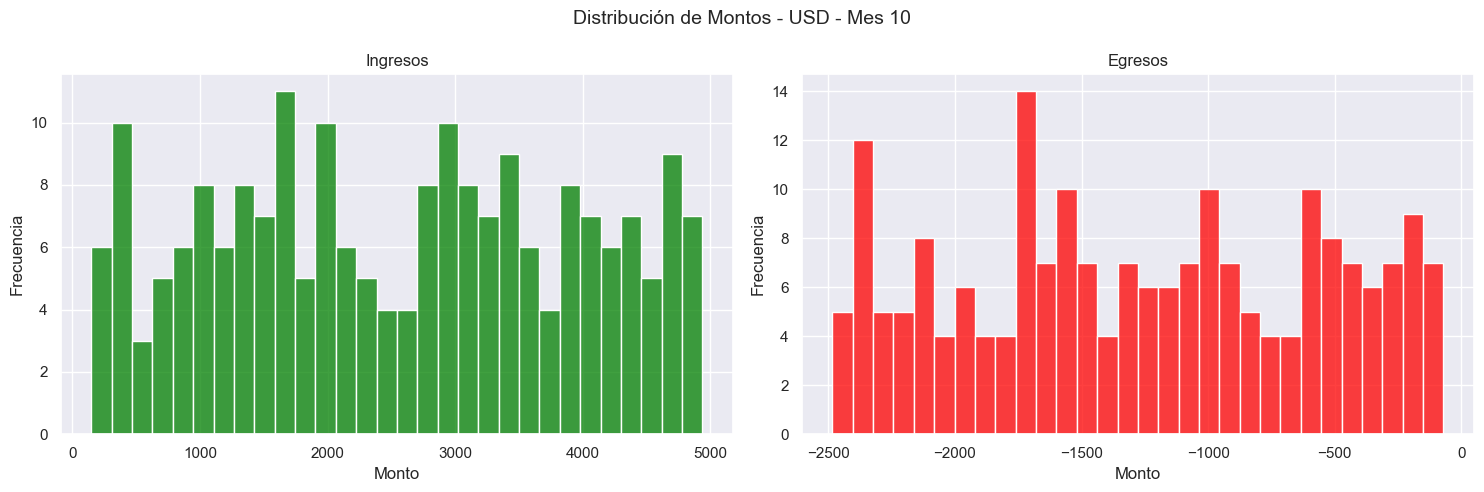

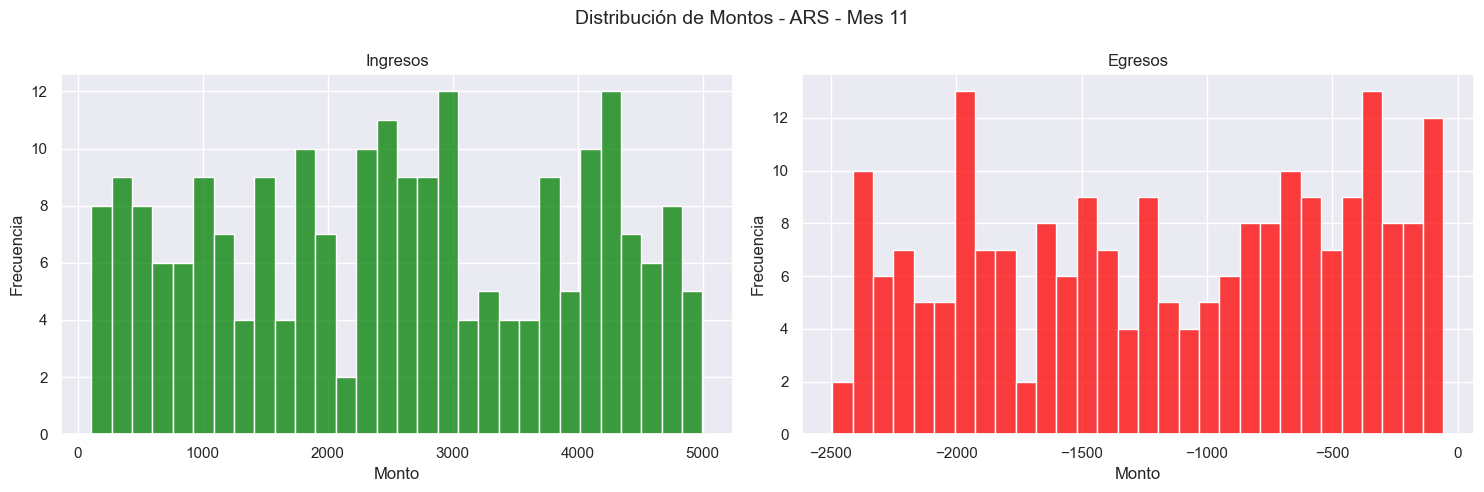

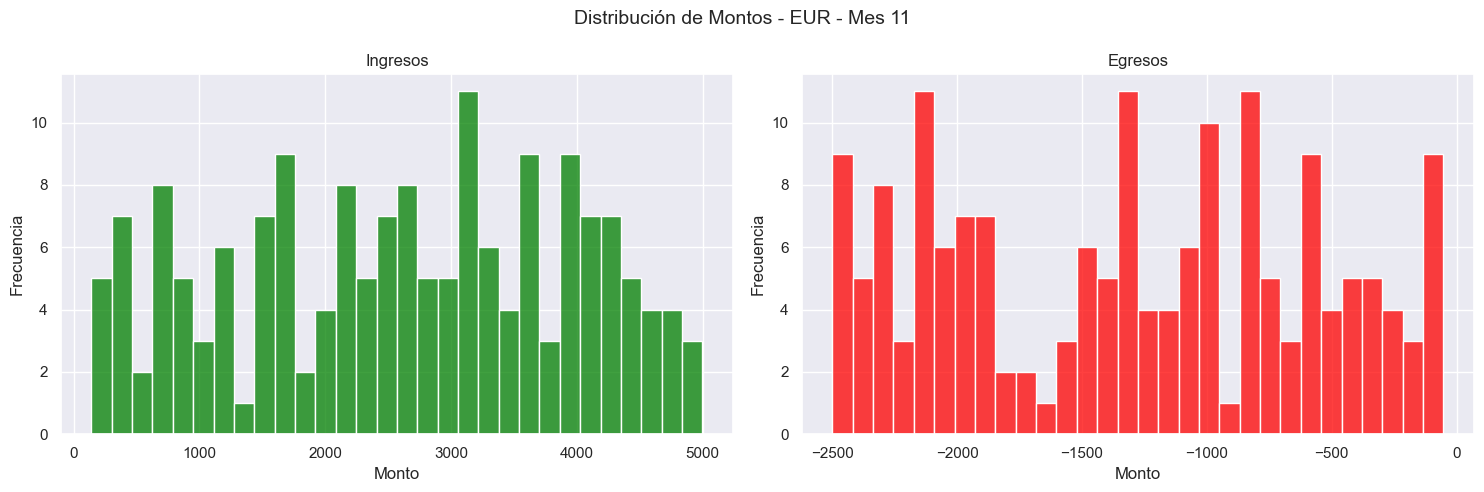

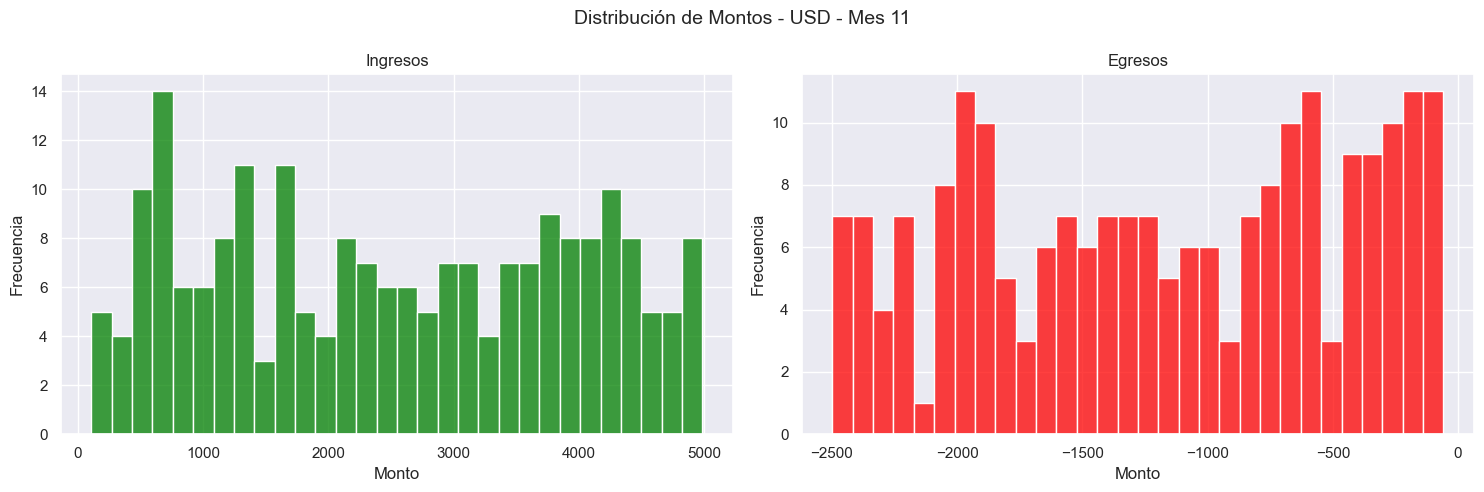

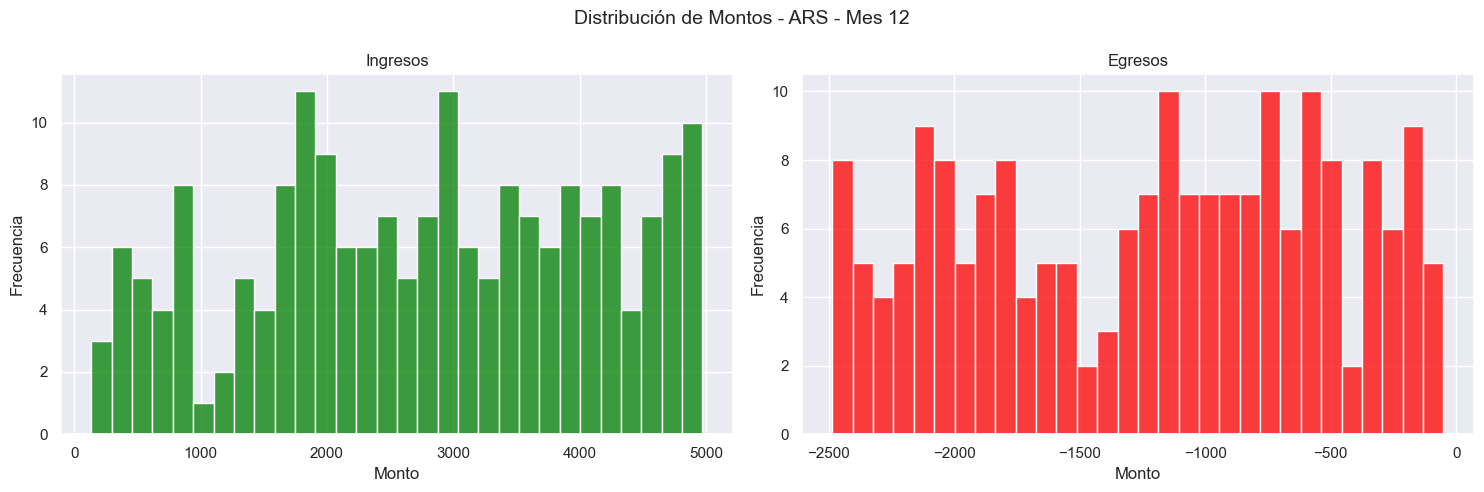

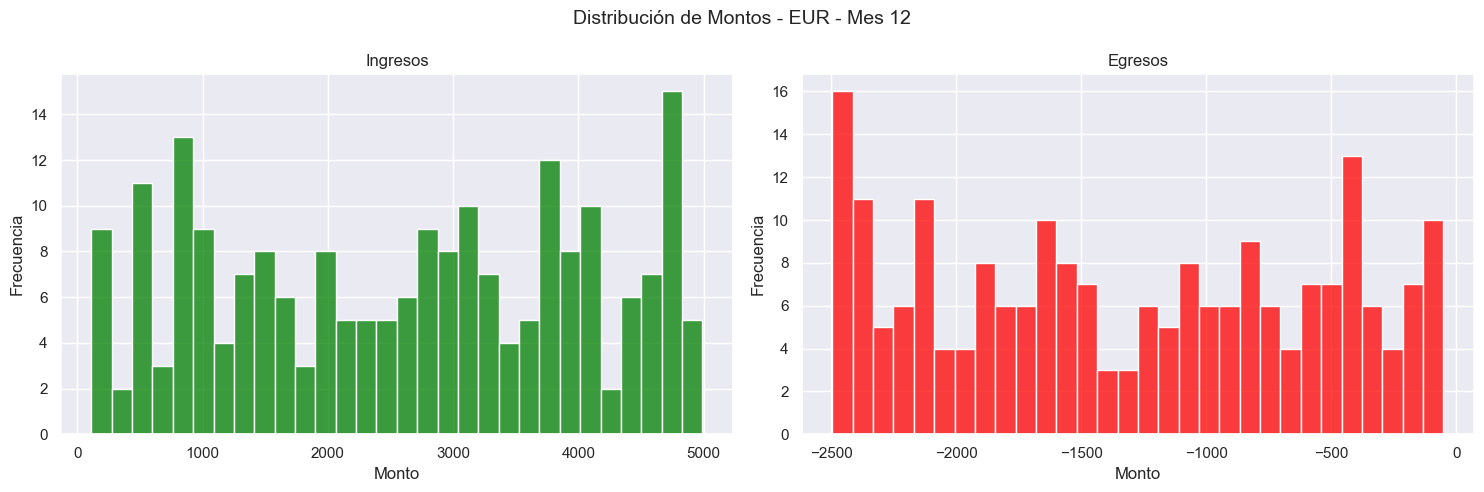

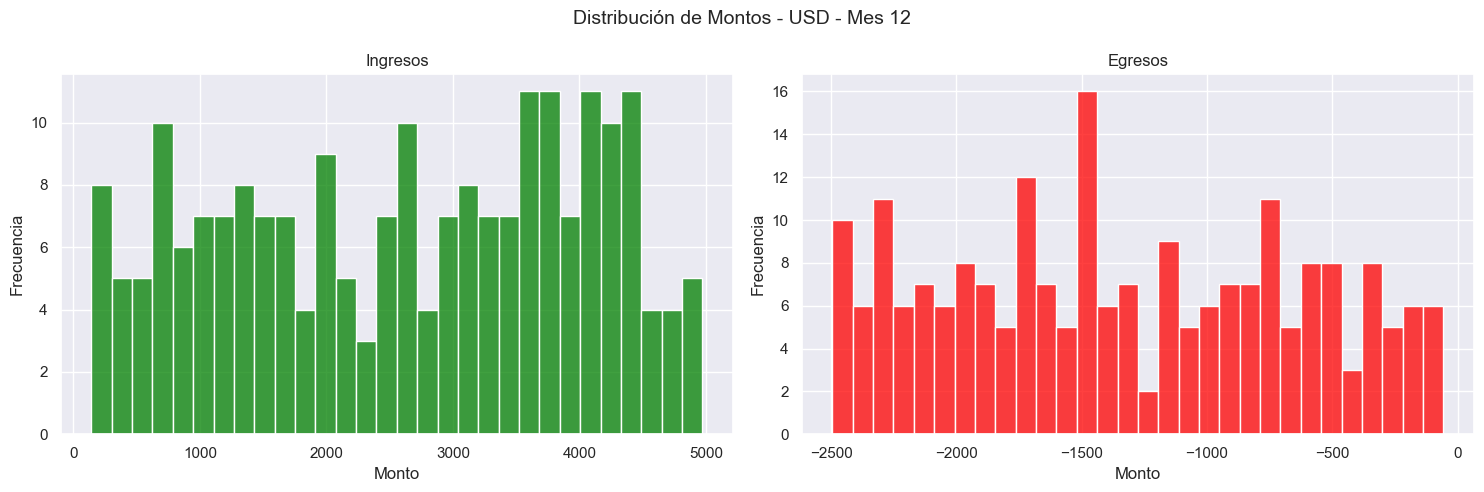

In [31]:

# Busco las lista única de meses y monedas

meses_unicos = df['Mes'].unique()
monedas_unicas = df['Moneda'].unique()

# configurar el tamaño de la figura para acomodar todos los meses

plt.figure(figsize=(15, 6 * len(meses_unicos)))

# Recorrer cada mes y moneda

for i, mes in enumerate(sorted(meses_unicos)):
    for j, moneda in enumerate(monedas_unicas):
        
        # seleccionar los datos del mes y moneda específicos
        datos_mes_moneda = df[(df['Mes'] == mes) & (df['Moneda'] == moneda)]
        
        # subplots lado a lado
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        fig.suptitle(f'Distribución de Montos - {moneda} - Mes {mes}', fontsize=14)
        
        # Ingresos
        ingresos = datos_mes_moneda[datos_mes_moneda['TipoMovimiento'] == 'Ingreso']
        if not ingresos.empty:
            sns.histplot(ingresos['Monto'], bins=30, ax=ax1, color='green')
            ax1.set_title('Ingresos')
            ax1.set_xlabel("Monto")
            ax1.set_ylabel("Frecuencia")
        else:
            ax1.text(0.5, 0.5, 'Sin datos de ingresos', ha='center', va='center')
            ax1.set_title('Ingresos (sin datos)')
        
        # Egresos
        egresos = datos_mes_moneda[datos_mes_moneda['TipoMovimiento'] == 'Egreso']
        if not egresos.empty:
            sns.histplot(egresos['Monto'],  bins=30, ax=ax2, color='red')
            ax2.set_title('Egresos')
            ax2.set_xlabel("Monto")
            ax2.set_ylabel("Frecuencia")
        else:
            ax2.text(0.5, 0.5, 'Sin datos de egresos', ha='center', va='center')
            ax2.set_title('Egresos (sin datos)')
        
        plt.tight_layout()
        plt.show()